In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt

from metpy.units import units
import metpy.calc as mpcalc

In [2]:
def create_date_predictors(data, date_col_name):
    data['Year'] = data[date_col_name].dt.year
    data['Month'] = data[date_col_name].dt.month
    data['Week'] = data[date_col_name].dt.isocalendar().week
    data['Year-Month'] = data['Year'].astype('str') + "-" + data['Month'].astype('str')
    data['Year-Week'] = data['Year'].astype('str') + "-" + data['Week'].astype('str')
    
    return data

def plot_boxplot_lineplot(data, x, y, title=None):
    fig,ax = plt.subplots(1,2, figsize=(10,5))
    sns.boxplot(x=x, y=y, data=data, ax=ax[0])
    sns.lineplot(x=x, y=y, data=data, ax=ax[1])
    fig.suptitle(title, fontsize=15, fontweight='bold')
    
    
def plot_4_boxplot_lineplot(data, x_list, y_list, plotTitle_list=None):
    fig,ax = plt.subplots(2,4, figsize=(20,10))
    if len(x_list)==len(y_list):
        for i in range(len(x_list)):
            sns.boxplot(x=x_list[i], y=y_list[i], data=data, ax=ax[0, i])
            sns.lineplot(x=x_list[i], y=y_list[i], data=data, ax=ax[1, i])
            ax[0, i].set_title(plotTitle_list[i], fontsize=12, fontweight='bold')

### Loading Data

In [3]:
# Load weather data
weather = pd.read_csv('../code/main/assets/cleaned_datasets/weather_clean.csv')

# Set all data types correctly
weather['Date'] = pd.to_datetime(weather['Date'])
weather['Sunrise_1'] = pd.to_datetime(weather['Sunrise_1'])
weather['Sunset_1'] = pd.to_datetime(weather['Sunset_1'])

# Create date related predictors
weather = create_date_predictors(weather, 'Date')

weather.head()

Date  Tmax_1  Tmin_1  Tavg_1  Depart_1  DewPoint_1  WetBulb_1  \
0 2007-05-01      83      50    67.0      14.0          51       56.0   
1 2007-05-02      59      42    51.0      -3.0          42       47.0   
2 2007-05-03      66      46    56.0       2.0          40       48.0   
3 2007-05-04      66      49    58.0       4.0          41       50.0   
4 2007-05-05      66      53    60.0       5.0          38       49.0   

            Sunrise_1            Sunset_1 CodeSum_1  ...  PrecipTotal_2  \
0 2007-05-01 04:48:00 2007-05-01 18:49:00        MD  ...          0.000   
1 2007-05-02 04:47:00 2007-05-02 18:50:00        BR  ...          0.000   
2 2007-05-03 04:46:00 2007-05-03 18:51:00        MD  ...          0.000   
3 2007-05-04 04:44:00 2007-05-04 18:52:00        RA  ...          0.000   
4 2007-05-05 04:43:00 2007-05-05 18:53:00        MD  ...          0.001   

   StnPressure_2  ResultSpeed_2  ResultDir_2  AvgSpeed_2  Year  Month  Week  \
0          29.18            2.7           25         9.6  2007      5    18   
1          29.44           13.3            2        13.4  2007      5    18   
2          29.46           12.9            6        13.2  2007      5    18   
3          29.36           10.1            7        10.4  2007      5    18   
4          29.46           11.2            7        11.5  2007      5    18   

   Year-Month  Year-Week  
0      2007-5    2007-18  
1      2007-5    2007-18  
2      2007-5    2007-18  
3      2007-5    2007-18  
4      2007-5    2007-18  

[5 rows x 32 columns]

In [4]:
# Load Train data
train = pd.read_csv('.././assets/train.csv')

# Drop rows with accuracy equal to 3 as these rows contain very generic address and not a specific location
train.drop(index=train[train['AddressAccuracy']==3].index, inplace=True)

# Drop address, block, street, AddressNumberAndStreet as these informations are not useful for modeling
train.drop(columns=['Trap', 'Block', 'Street', 'AddressNumberAndStreet'], inplace=True)

# Set all data types correctly
train['Date'] = pd.to_datetime(train['Date'])

# Create date related predictors
train = create_date_predictors(train, 'Date')

train.head()

Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species   Latitude  Longitude  AddressAccuracy  \
0  CULEX PIPIENS/RESTUANS  41.954690 -87.800991                9   
1          CULEX RESTUANS  41.954690 -87.800991                9   
2          CULEX RESTUANS  41.994991 -87.769279                9   
3  CULEX PIPIENS/RESTUANS  41.974089 -87.824812                8   
4          CULEX RESTUANS  41.974089 -87.824812                8   

   NumMosquitos  WnvPresent  Year  Month  Week Year-Month Year-Week  
0             1           0  2007      5    22     2007-5   2007-22  
1             1           0  2007      5    22     2007-5   2007-22  
2             1           0  2007      5    22     2007-5   2007-22  
3             1           0  2007      5    22     2007-5   2007-22  
4             4           0  2007      5    22     2007-5   2007-22

### EDA for Train Data Set

Only CULEX PIPIENS/RESTUANS, CULEX PIPIENS and CULEX RESTUANS carry West Nile Virus. CULEX SALINARIUS, CULEX TERRITANS, CULEX TARSALIS and CULEX ERRATICUS do not carry West Nile Virus.

In [5]:
# Breeds of mosquitoes that carries West Nile Virus
wnv_species = train[train['WnvPresent']==1]['Species'].unique()
wnv_species

array(['CULEX PIPIENS/RESTUANS', 'CULEX PIPIENS', 'CULEX RESTUANS'],
      dtype=object)

In [6]:
# If Mosquitoes is of the 3 types, Is Wnv Mosquitoes Types is 1
train['Is Wnv Mosquitoes Types'] = train['Species'].apply(lambda x: 1 if x in wnv_species else 0)

In [7]:
train

Date                                            Address  \
0     2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1     2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2     2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3     2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4     2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
...          ...                                                ...   
10501 2013-09-26      5100 West 72nd Street, Chicago, IL 60638, USA   
10502 2013-09-26    5800 North Ridge Avenue, Chicago, IL 60660, USA   
10503 2013-09-26  1700 North Ashland Avenue, Chicago, IL 60622, USA   
10504 2013-09-26   7100 North Harlem Avenue, Chicago, IL 60631, USA   
10505 2013-09-26      4200 West 65th Street, Chicago, IL 60621, USA   

                      Species   Latitude  Longitude  AddressAccuracy  \
0      CULEX PIPIENS/RESTUANS  41.954690 -87.800991                9   
1              CULEX RESTUANS  41.954690 -87.800991                9   
2              CULEX RESTUANS  41.994991 -87.769279                9   
3      CULEX PIPIENS/RESTUANS  41.974089 -87.824812                8   
4              CULEX RESTUANS  41.974089 -87.824812                8   
...                       ...        ...        ...              ...   
10501  CULEX PIPIENS/RESTUANS  41.763733 -87.742302                8   
10502  CULEX PIPIENS/RESTUANS  41.987280 -87.666066                8   
10503  CULEX PIPIENS/RESTUANS  41.912563 -87.668055                9   
10504  CULEX PIPIENS/RESTUANS  42.009876 -87.807277                9   
10505  CULEX PIPIENS/RESTUANS  41.776428 -87.627096                8   

       NumMosquitos  WnvPresent  Year  Month  Week Year-Month Year-Week  \
0                 1           0  2007      5    22     2007-5   2007-22   
1                 1           0  2007      5    22     2007-5   2007-22   
2                 1           0  2007      5    22     2007-5   2007-22   
3                 1           0  2007      5    22     2007-5   2007-22   
4                 4           0  2007      5    22     2007-5   2007-22   
...             ...         ...   ...    ...   ...        ...       ...   
10501             6           1  2013      9    39     2013-9   2013-39   
10502             5           0  2013      9    39     2013-9   2013-39   
10503             1           0  2013      9    39     2013-9   2013-39   
10504             5           0  2013      9    39     2013-9   2013-39   
10505             1           0  2013      9    39     2013-9   2013-39   

       Is Wnv Mosquitoes Types  
0                            1  
1                            1  
2                            1  
3                            1  
4                            1  
...                        ...  
10501                        1  
10502                        1  
10503                        1  
10504                        1  
10505                        1  

[10415 rows x 14 columns]

In [8]:
train.set_index('Date', drop=False, inplace=True)

In [9]:
temp = train['NumMosquitos'].resample('W').mean()
temp = pd.DataFrame(temp)

temp['Year'] = temp.index.year
temp['Month'] = temp.index.month
temp['Week'] = temp.index.isocalendar().week
temp['Year-Week'] = temp['Year'].astype('str') + "-" + temp['Week'].astype('str')
temp.drop(columns=['NumMosquitos'], inplace=True)
temp.reset_index(inplace=True)
weekly_date_df = temp.drop_duplicates()

In [10]:
# Get sum of Mosquitoes for each trap, date and 'Is Wnv Mosquitoes Types'
train_sum = train[['Date', 'Species', 'Is Wnv Mosquitoes Types', 'Latitude', 'Longitude', 'NumMosquitos', 'WnvPresent', 'Year-Week']].groupby(['Year-Week', 'Species', 'Is Wnv Mosquitoes Types', 'Latitude', 'Longitude'])[['NumMosquitos', 'WnvPresent']].sum()
train_sum = train_sum.reset_index()
train_sum['WnvPresent'] = train_sum['WnvPresent'].apply(lambda x: 1 if x > 0 else 0)

In [11]:
train_sum = pd.merge(left=train_sum,
                    right=weekly_date_df,
                    on='Year-Week',
                    how='left', )
train_sum.set_index('Date', inplace=True)

In [12]:
train_sum

Year-Week                 Species  Is Wnv Mosquitoes Types  \
Date                                                                    
2007-06-03   2007-22           CULEX PIPIENS                        1   
2007-06-03   2007-22  CULEX PIPIENS/RESTUANS                        1   
2007-06-03   2007-22  CULEX PIPIENS/RESTUANS                        1   
2007-06-03   2007-22  CULEX PIPIENS/RESTUANS                        1   
2007-06-03   2007-22  CULEX PIPIENS/RESTUANS                        1   
...              ...                     ...                      ...   
2013-09-29   2013-39          CULEX RESTUANS                        1   
2013-09-29   2013-39          CULEX RESTUANS                        1   
2013-09-29   2013-39          CULEX RESTUANS                        1   
2013-09-29   2013-39          CULEX RESTUANS                        1   
2013-09-29   2013-39          CULEX RESTUANS                        1   

             Latitude  Longitude  NumMosquitos  WnvPresent  Year  Month  Week  
Date                                                                           
2007-06-03  41.731922 -87.677512             1           0  2007      6    22  
2007-06-03  41.688324 -87.676709             1           0  2007      6    22  
2007-06-03  41.867108 -87.654224             1           0  2007      6    22  
2007-06-03  41.891126 -87.611560             1           0  2007      6    22  
2007-06-03  41.919343 -87.694259             1           0  2007      6    22  
...               ...        ...           ...         ...   ...    ...   ...  
2013-09-29  41.750498 -87.605294             1           0  2013      9    39  
2013-09-29  41.803423 -87.642984             2           0  2013      9    39  
2013-09-29  41.867108 -87.654224             7           0  2013      9    39  
2013-09-29  41.963976 -87.691810             8           0  2013      9    39  
2013-09-29  41.992478 -87.862995             1           0  2013      9    39  

[7481 rows x 10 columns]

### EDA for Weather

In [13]:
weather.columns

Index(['Date', 'Tmax_1', 'Tmin_1', 'Tavg_1', 'Depart_1', 'DewPoint_1',
       'WetBulb_1', 'Sunrise_1', 'Sunset_1', 'CodeSum_1', 'SnowFall_1',
       'PrecipTotal_1', 'StnPressure_1', 'ResultSpeed_1', 'ResultDir_1',
       'AvgSpeed_1', 'Tmax_2', 'Tmin_2', 'Tavg_2', 'DewPoint_2', 'WetBulb_2',
       'CodeSum_2', 'PrecipTotal_2', 'StnPressure_2', 'ResultSpeed_2',
       'ResultDir_2', 'AvgSpeed_2', 'Year', 'Month', 'Week', 'Year-Month',
       'Year-Week'],
      dtype='object')

In [14]:
# Since mosquitoes dies/greatly inhibited at temperature below 50F, to create 4 additional predictors to indicate this for Tavg and Tmin
weather['Tavg_1_Below_50F'] = weather['Tavg_1'].apply(lambda x: 1 if x < 50 else 0)
weather['Tmin_1_Below_50F'] = weather['Tmin_1'].apply(lambda x: 1 if x < 50 else 0)
weather['Tavg_2_Below_50F'] = weather['Tavg_2'].apply(lambda x: 1 if x < 50 else 0)
weather['Tmin_2_Below_50F'] = weather['Tmin_2'].apply(lambda x: 1 if x < 50 else 0)

# Calculate duration of daylight
weather['Daylight_Duration'] = (weather['Sunset_1'] - weather['Sunrise_1']).dt.total_seconds()/60

# Calculate relative humidity
weather['RH_1'] = mpcalc.relative_humidity_from_dewpoint(weather['Tavg_1'].values * units.degF, weather['DewPoint_1'].values * units.degF)
weather['RH_2'] = mpcalc.relative_humidity_from_dewpoint(weather['Tavg_2'].values * units.degF, weather['DewPoint_2'].values * units.degF)

In [15]:
# Split CodeSum_1 into a list
temp_list = []
for i in weather['CodeSum_1'].unique():
    temp_list.extend(i.split(" "))

temp_list2 = set(temp_list)
temp_list = []

for i in temp_list2:
    if len(i)>2:
        temp_list.extend([i[:2], i[2:]])
    else:
        temp_list.append(i)

codesum_1_list = temp_list

# Split CodeSum_2 into a list
temp_list = []
for i in weather['CodeSum_2'].unique():
    temp_list.extend(i.split(" "))

temp_list2 = set(temp_list)
temp_list = []

for i in temp_list2:
    if len(i)>2:
        temp_list.extend([i[:2], i[2:]])
    else:
        temp_list.append(i)

codesum_2_list = temp_list

print(f'Weather Conditions: {set(codesum_1_list + codesum_2_list)}')

Weather Conditions: {'RA', 'FG', 'BR', 'HZ', 'SQ', 'BC', 'FU', 'TS', 'DZ', 'VC', 'SN', 'GR', 'MI', 'MD', '+'}


In [16]:
# Define wet weather
wet_weather = ['GR', 'TS', 'RA', 'DZ', 'GS', 'UP', 'SQ', 'SH', 'PY', 'SN', 'SG', 'PL', 'IC']

# Check if the day is a wet weather
weather['Wet_Weather_1'] = weather['CodeSum_1'].apply(lambda x: int(any([1 if weather in x else 0 for weather in wet_weather])))
weather['Wet_Weather_2'] = weather['CodeSum_2'].apply(lambda x: int(any([1 if weather in x else 0 for weather in wet_weather])))

In [17]:
# Set Date as index
weather.set_index('Date', inplace=True)

In [18]:
# Shift Wet_Weather and PrecipTotal by 7 days
temp = weather[['Wet_Weather_1', 'Wet_Weather_2', 'PrecipTotal_1', 'PrecipTotal_2']].shift(7)
temp.rename(columns={'Wet_Weather_1': 'Wet_Weather_1_shift7', 
                     'Wet_Weather_2': 'Wet_Weather_2_shift7', 
                     'PrecipTotal_1': 'PrecipTotal_1_shift7',
                     'PrecipTotal_2': 'PrecipTotal_2_shift7'}, inplace=True)
weather = weather.merge(right=temp,
             how='left',
             left_index=True,
             right_index=True)

In [19]:
# Shift Wet_Weather and PrecipTotal by 14 days
temp = weather[['Wet_Weather_1', 'Wet_Weather_2', 'PrecipTotal_1', 'PrecipTotal_2']].shift(14)
temp.rename(columns={'Wet_Weather_1': 'Wet_Weather_1_shift14', 
                     'Wet_Weather_2': 'Wet_Weather_2_shift14', 
                     'PrecipTotal_1': 'PrecipTotal_1_shift14',
                     'PrecipTotal_2': 'PrecipTotal_2_shift14'}, inplace=True)
weather = weather.merge(right=temp,
             how='left',
             left_index=True,
             right_index=True)

In [20]:
# Shift Wet_Weather and PrecipTotal by 21 days
temp = weather[['Wet_Weather_1', 'Wet_Weather_2', 'PrecipTotal_1', 'PrecipTotal_2']].shift(21)
temp.rename(columns={'Wet_Weather_1': 'Wet_Weather_1_shift21', 
                     'Wet_Weather_2': 'Wet_Weather_2_shift21', 
                     'PrecipTotal_1': 'PrecipTotal_1_shift21',
                     'PrecipTotal_2': 'PrecipTotal_2_shift21'}, inplace=True)
weather = weather.merge(right=temp,
             how='left',
             left_index=True,
             right_index=True)

In [21]:
# Shift Wet_Weather and PrecipTotal by 28 days
temp = weather[['Wet_Weather_1', 'Wet_Weather_2', 'PrecipTotal_1', 'PrecipTotal_2']].shift(28)
temp.rename(columns={'Wet_Weather_1': 'Wet_Weather_1_shift28', 
                     'Wet_Weather_2': 'Wet_Weather_2_shift28', 
                     'PrecipTotal_1': 'PrecipTotal_1_shift28',
                     'PrecipTotal_2': 'PrecipTotal_2_shift28'}, inplace=True)
weather = weather.merge(right=temp,
             how='left',
             left_index=True,
             right_index=True)

In [22]:
#create dataframe for weekly, monthly and yearly
weather_weekly = weather.resample('W').mean()
weather_monthly = weather.resample('M').mean()

Text(0.5, 1.0, 'Average Temp Trend By Station')

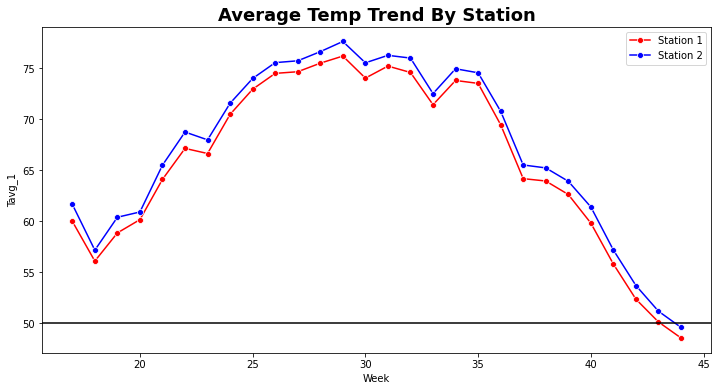

In [23]:
# Plot average temp trend by stations
plt.figure(figsize=(12,6))
sns.lineplot(x='Week', y='Tavg_1', data=weather, err_style=None, marker='o', color='red', label='Station 1')
sns.lineplot(x='Week', y='Tavg_2', data=weather, err_style=None, marker='o', color='blue', label='Station 2')
plt.axhline(50, color='black')
plt.legend()
plt.title('Average Temp Trend By Station', fontsize=18, fontweight='bold')

Text(0.5, 1.0, 'Minimum Temp Trend By Station')

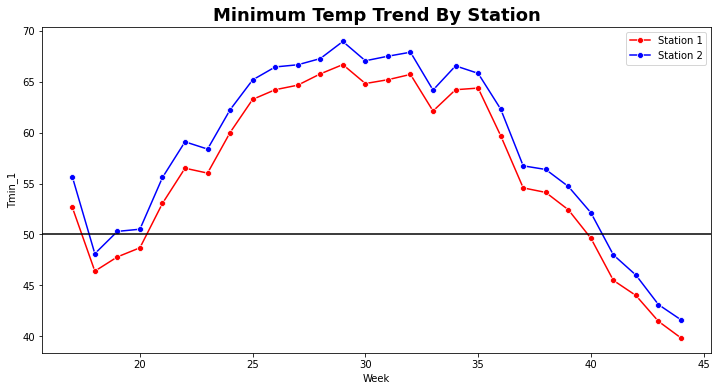

In [24]:
# Plot min temp trend by stations
plt.figure(figsize=(12,6))
sns.lineplot(x='Week', y='Tmin_1', data=weather, err_style=None, marker='o', color='red', label='Station 1')
sns.lineplot(x='Week', y='Tmin_2', data=weather, err_style=None, marker='o', color='blue', label='Station 2')
plt.axhline(50, color='black')
plt.legend()
plt.title('Minimum Temp Trend By Station', fontsize=18, fontweight='bold')

Text(0.5, 0.98, 'Average Temperature Trend')

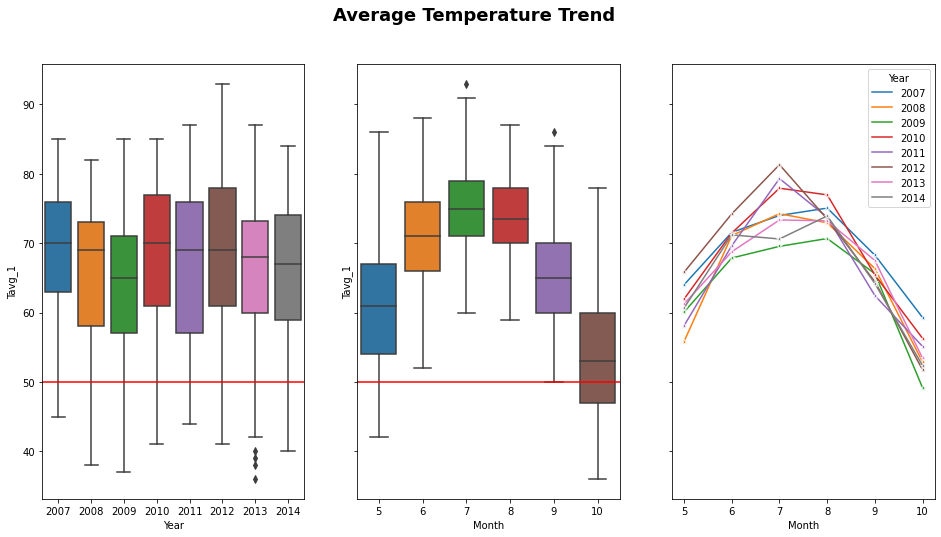

In [25]:
# Plot average temp trend
fig, ax = plt.subplots(1,3, figsize=(16,8), sharey=True)
sns.boxplot(x='Year', y='Tavg_1', data=weather, ax=ax[0])
ax[0].axhline(50, color='red')
sns.boxplot(x='Month', y='Tavg_1', data=weather, ax=ax[1])
ax[1].axhline(50, color='red')
sns.lineplot(x='Month', y='Tavg_1', data=weather, hue='Year', err_style=None, marker='*', ax=ax[2], palette='tab10')
plt.suptitle('Average Temperature Trend', fontsize=18, fontweight='bold')

Text(0.5, 0.98, 'Min Temperature Trend')

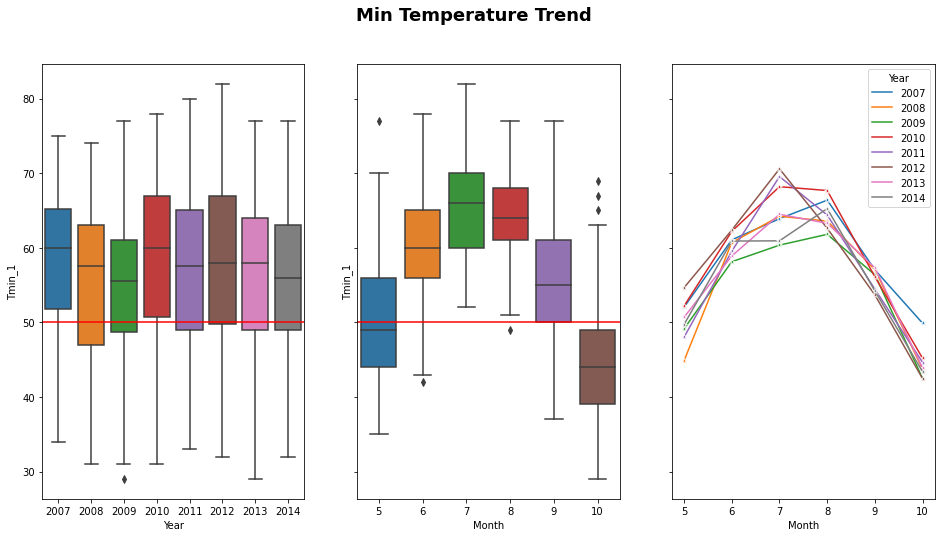

In [26]:
# Plot min temp trend
fig, ax = plt.subplots(1,3, figsize=(16,8), sharey=True)
sns.boxplot(x='Year', y='Tmin_1', data=weather, ax=ax[0])
ax[0].axhline(50, color='red')
sns.boxplot(x='Month', y='Tmin_1', data=weather, ax=ax[1])
ax[1].axhline(50, color='red')
sns.lineplot(x='Month', y='Tmin_1', data=weather, hue='Year', err_style=None, marker='*', ax=ax[2], palette='tab10')
plt.suptitle('Min Temperature Trend', fontsize=18, fontweight='bold')

Text(0.5, 0.98, 'Total Precipitation Trend At Each Station')

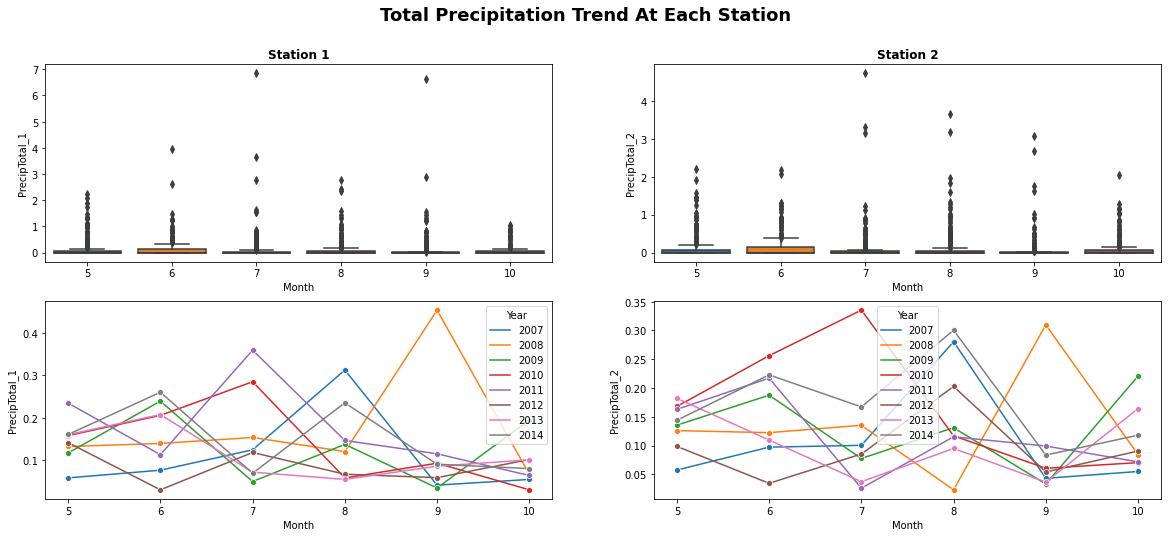

In [27]:
# Plot total precipitation trend
fig, ax = plt.subplots(2,2, figsize=(20,8))
ax[0,0].set_title('Station 1', fontsize=12, fontweight='bold')
sns.boxplot(x='Month', y='PrecipTotal_1', data=weather, ax=ax[0,0])
sns.lineplot(x='Month', y='PrecipTotal_1', data=weather, marker='o', hue='Year', err_style=None, ax=ax[1,0], palette='tab10')

ax[0,1].set_title('Station 2', fontsize=12, fontweight='bold')
sns.boxplot(x='Month', y='PrecipTotal_2', data=weather, ax=ax[0,1])
sns.lineplot(x='Month', y='PrecipTotal_2', data=weather, marker='o', hue='Year', err_style=None, ax=ax[1,1], palette='tab10')
plt.suptitle('Total Precipitation Trend At Each Station', fontsize=18, fontweight='bold')

Text(0.5, 0.98, 'Relative Humidity Trend At Each Station')

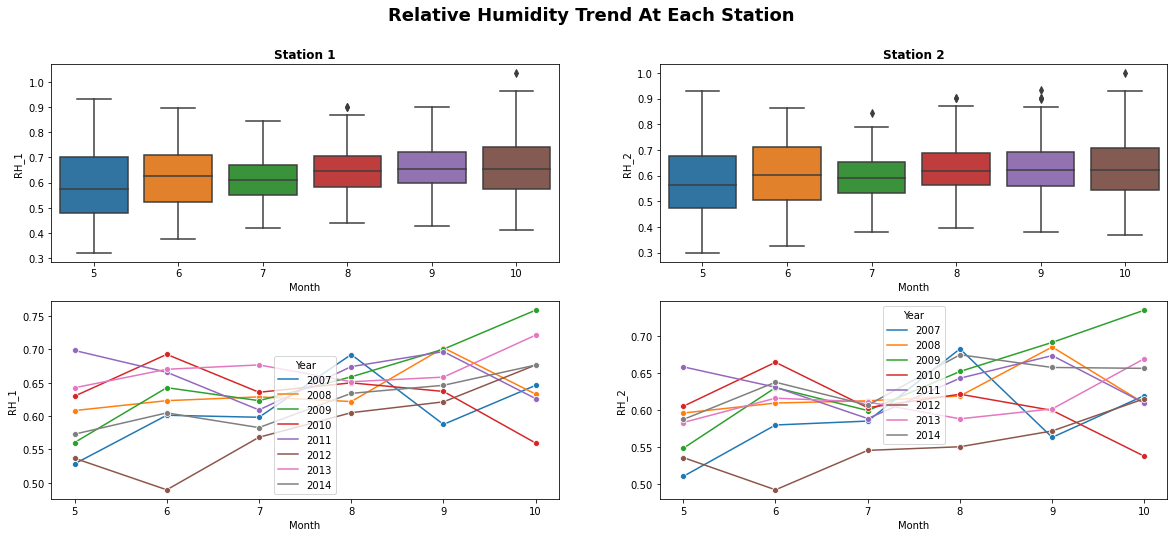

In [28]:
# Plot RH trend
fig, ax = plt.subplots(2,2, figsize=(20,8))
ax[0,0].set_title('Station 1', fontsize=12, fontweight='bold')
sns.boxplot(x='Month', y='RH_1', data=weather, ax=ax[0,0])
sns.lineplot(x='Month', y='RH_1', data=weather, marker='o', hue='Year', err_style=None, ax=ax[1,0], palette='tab10')

ax[0,1].set_title('Station 2', fontsize=12, fontweight='bold')
sns.boxplot(x='Month', y='RH_2', data=weather, ax=ax[0,1])
sns.lineplot(x='Month', y='RH_2', data=weather, marker='o', hue='Year', err_style=None, ax=ax[1,1], palette='tab10')
plt.suptitle('Relative Humidity Trend At Each Station', fontsize=18, fontweight='bold')

Text(0.5, 0.98, 'Daylight Duration Trend')

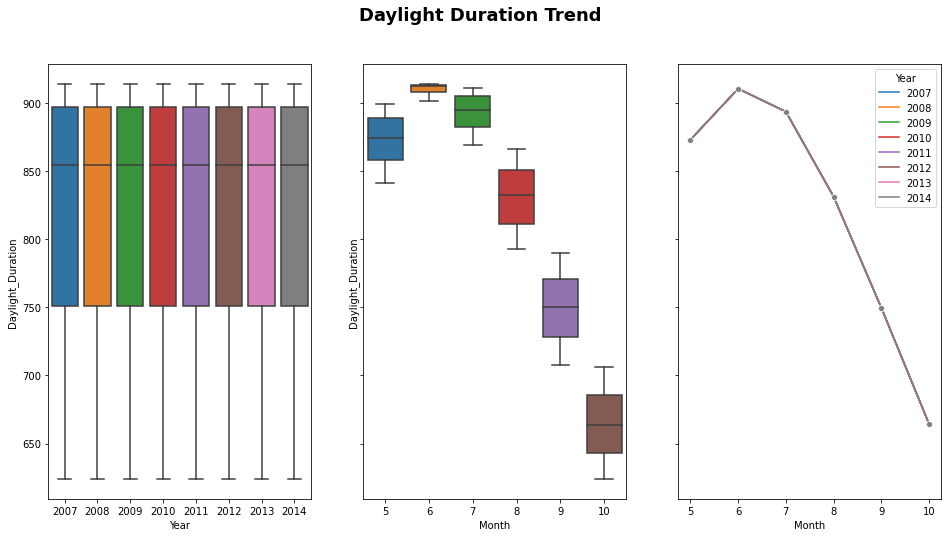

In [29]:
# Plot daylight duration trend
fig, ax = plt.subplots(1,3, figsize=(16,8), sharey=True)
sns.boxplot(x='Year', y='Daylight_Duration', data=weather, ax=ax[0])
sns.boxplot(x='Month', y='Daylight_Duration', data=weather, ax=ax[1])
sns.lineplot(x='Month', y='Daylight_Duration', data=weather, hue='Year', err_style=None, marker='o', ax=ax[2], palette='tab10')
plt.suptitle('Daylight Duration Trend', fontsize=18, fontweight='bold')

Text(0.5, 0.98, 'Pressure Trend At Each Station')

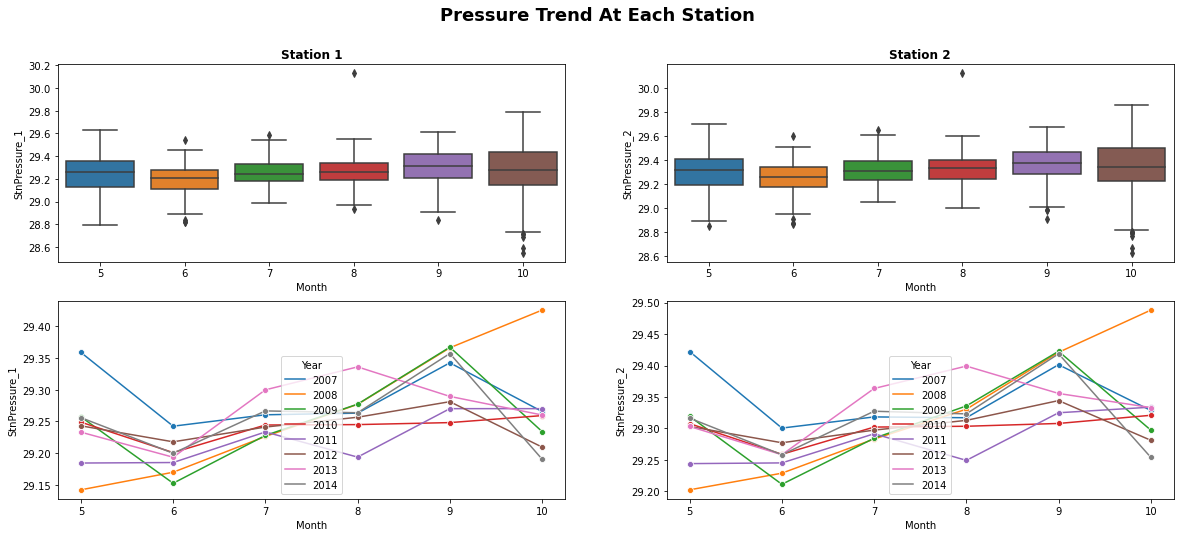

In [30]:
# Plot Pressure trend
fig, ax = plt.subplots(2,2, figsize=(20,8))
ax[0,0].set_title('Station 1', fontsize=12, fontweight='bold')
sns.boxplot(x='Month', y='StnPressure_1', data=weather, ax=ax[0,0])
sns.lineplot(x='Month', y='StnPressure_1', data=weather, marker='o', hue='Year', err_style=None, ax=ax[1,0], palette='tab10')

ax[0,1].set_title('Station 2', fontsize=12, fontweight='bold')
sns.boxplot(x='Month', y='StnPressure_2', data=weather, ax=ax[0,1])
sns.lineplot(x='Month', y='StnPressure_2', data=weather, marker='o', hue='Year', err_style=None, ax=ax[1,1], palette='tab10')
plt.suptitle('Pressure Trend At Each Station', fontsize=18, fontweight='bold')

Text(0.5, 0.98, 'Resultant Speed Trend At Each Station')

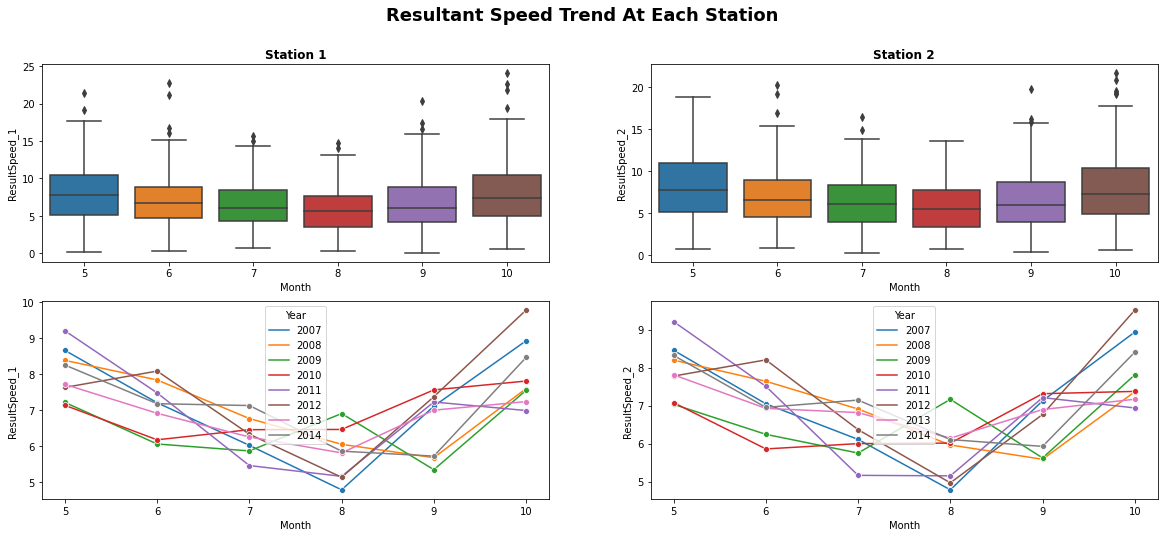

In [31]:
# Plot Resultant Speed trend
fig, ax = plt.subplots(2,2, figsize=(20,8))
ax[0,0].set_title('Station 1', fontsize=12, fontweight='bold')
sns.boxplot(x='Month', y='ResultSpeed_1', data=weather, ax=ax[0,0])
sns.lineplot(x='Month', y='ResultSpeed_1', data=weather, marker='o', hue='Year', err_style=None, ax=ax[1,0], palette='tab10')

ax[0,1].set_title('Station 2', fontsize=12, fontweight='bold')
sns.boxplot(x='Month', y='ResultSpeed_2', data=weather, ax=ax[0,1])
sns.lineplot(x='Month', y='ResultSpeed_2', data=weather, marker='o', hue='Year', err_style=None, ax=ax[1,1], palette='tab10')
plt.suptitle('Resultant Speed Trend At Each Station', fontsize=18, fontweight='bold')

Text(0.5, 0.98, 'Resultant Speed Trend At Each Station')

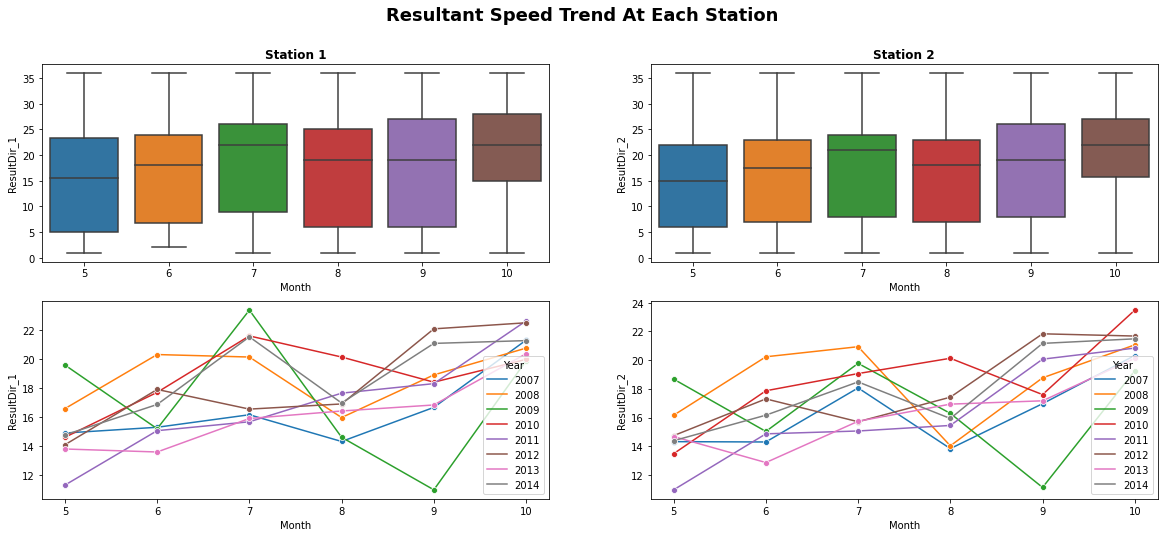

In [32]:
# Plot Resultant Direction trend
fig, ax = plt.subplots(2,2, figsize=(20,8))
ax[0,0].set_title('Station 1', fontsize=12, fontweight='bold')
sns.boxplot(x='Month', y='ResultDir_1', data=weather, ax=ax[0,0])
sns.lineplot(x='Month', y='ResultDir_1', data=weather, marker='o', hue='Year', err_style=None, ax=ax[1,0], palette='tab10')

ax[0,1].set_title('Station 2', fontsize=12, fontweight='bold')
sns.boxplot(x='Month', y='ResultDir_2', data=weather, ax=ax[0,1])
sns.lineplot(x='Month', y='ResultDir_2', data=weather, marker='o', hue='Year', err_style=None, ax=ax[1,1], palette='tab10')
plt.suptitle('Resultant Speed Trend At Each Station', fontsize=18, fontweight='bold')

### EDA for Train_Weather_Weekly merge dataset

In [33]:
train_weather_weekly = pd.merge(left=train_sum,
                                right=weather_weekly,
                                left_index=True,
                                right_index=True,
                                how='left'
                               )
train_weather_weekly

Year-Week                 Species  Is Wnv Mosquitoes Types  \
Date                                                                    
2007-06-03   2007-22           CULEX PIPIENS                        1   
2007-06-03   2007-22  CULEX PIPIENS/RESTUANS                        1   
2007-06-03   2007-22  CULEX PIPIENS/RESTUANS                        1   
2007-06-03   2007-22  CULEX PIPIENS/RESTUANS                        1   
2007-06-03   2007-22  CULEX PIPIENS/RESTUANS                        1   
...              ...                     ...                      ...   
2013-09-29   2013-39          CULEX RESTUANS                        1   
2013-09-29   2013-39          CULEX RESTUANS                        1   
2013-09-29   2013-39          CULEX RESTUANS                        1   
2013-09-29   2013-39          CULEX RESTUANS                        1   
2013-09-29   2013-39          CULEX RESTUANS                        1   

             Latitude  Longitude  NumMosquitos  WnvPresent  Year_x  Month_x  \
Date                                                                          
2007-06-03  41.731922 -87.677512             1           0    2007        6   
2007-06-03  41.688324 -87.676709             1           0    2007        6   
2007-06-03  41.867108 -87.654224             1           0    2007        6   
2007-06-03  41.891126 -87.611560             1           0    2007        6   
2007-06-03  41.919343 -87.694259             1           0    2007        6   
...               ...        ...           ...         ...     ...      ...   
2013-09-29  41.750498 -87.605294             1           0    2013        9   
2013-09-29  41.803423 -87.642984             2           0    2013        9   
2013-09-29  41.867108 -87.654224             7           0    2013        9   
2013-09-29  41.963976 -87.691810             8           0    2013        9   
2013-09-29  41.992478 -87.862995             1           0    2013        9   

            Week_x  ...  PrecipTotal_1_shift14  PrecipTotal_2_shift14  \
Date                ...                                                 
2007-06-03      22  ...               0.084286               0.111429   
2007-06-03      22  ...               0.084286               0.111429   
2007-06-03      22  ...               0.084286               0.111429   
2007-06-03      22  ...               0.084286               0.111429   
2007-06-03      22  ...               0.084286               0.111429   
...            ...  ...                    ...                    ...   
2013-09-29      39  ...               0.093143               0.043143   
2013-09-29      39  ...               0.093143               0.043143   
2013-09-29      39  ...               0.093143               0.043143   
2013-09-29      39  ...               0.093143               0.043143   
2013-09-29      39  ...               0.093143               0.043143   

            Wet_Weather_1_shift21  Wet_Weather_2_shift21  \
Date                                                       
2007-06-03               0.142857                    0.0   
2007-06-03               0.142857                    0.0   
2007-06-03               0.142857                    0.0   
2007-06-03               0.142857                    0.0   
2007-06-03               0.142857                    0.0   
...                           ...                    ...   
2013-09-29               0.000000                    0.0   
2013-09-29               0.000000                    0.0   
2013-09-29               0.000000                    0.0   
2013-09-29               0.000000                    0.0   
2013-09-29               0.000000                    0.0   

            PrecipTotal_1_shift21  PrecipTotal_2_shift21  \
Date                                                       
2007-06-03               0.018714                  0.003   
2007-06-03               0.018714                  0.003   
2007-06-03               0.018714                  0.003   
20

In [34]:
train_weather_weekly.drop(columns=['Year_y', 'Month_y', 'Week_y'], inplace=True)
train_weather_weekly.rename(columns={'Year_x': 'Year', 'Month_x': 'Month', 'Week_x': 'Week'}, inplace=True)
train_weather_weekly

Year-Week                 Species  Is Wnv Mosquitoes Types  \
Date                                                                    
2007-06-03   2007-22           CULEX PIPIENS                        1   
2007-06-03   2007-22  CULEX PIPIENS/RESTUANS                        1   
2007-06-03   2007-22  CULEX PIPIENS/RESTUANS                        1   
2007-06-03   2007-22  CULEX PIPIENS/RESTUANS                        1   
2007-06-03   2007-22  CULEX PIPIENS/RESTUANS                        1   
...              ...                     ...                      ...   
2013-09-29   2013-39          CULEX RESTUANS                        1   
2013-09-29   2013-39          CULEX RESTUANS                        1   
2013-09-29   2013-39          CULEX RESTUANS                        1   
2013-09-29   2013-39          CULEX RESTUANS                        1   
2013-09-29   2013-39          CULEX RESTUANS                        1   

             Latitude  Longitude  NumMosquitos  WnvPresent  Year  Month  Week  \
Date                                                                            
2007-06-03  41.731922 -87.677512             1           0  2007      6    22   
2007-06-03  41.688324 -87.676709             1           0  2007      6    22   
2007-06-03  41.867108 -87.654224             1           0  2007      6    22   
2007-06-03  41.891126 -87.611560             1           0  2007      6    22   
2007-06-03  41.919343 -87.694259             1           0  2007      6    22   
...               ...        ...           ...         ...   ...    ...   ...   
2013-09-29  41.750498 -87.605294             1           0  2013      9    39   
2013-09-29  41.803423 -87.642984             2           0  2013      9    39   
2013-09-29  41.867108 -87.654224             7           0  2013      9    39   
2013-09-29  41.963976 -87.691810             8           0  2013      9    39   
2013-09-29  41.992478 -87.862995             1           0  2013      9    39   

            ...  PrecipTotal_1_shift14  PrecipTotal_2_shift14  \
Date        ...                                                 
2007-06-03  ...               0.084286               0.111429   
2007-06-03  ...               0.084286               0.111429   
2007-06-03  ...               0.084286               0.111429   
2007-06-03  ...               0.084286               0.111429   
2007-06-03  ...               0.084286               0.111429   
...         ...                    ...                    ...   
2013-09-29  ...               0.093143               0.043143   
2013-09-29  ...               0.093143               0.043143   
2013-09-29  ...               0.093143               0.043143   
2013-09-29  ...               0.093143               0.043143   
2013-09-29  ...               0.093143               0.043143   

            Wet_Weather_1_shift21  Wet_Weather_2_shift21  \
Date                                                       
2007-06-03               0.142857                    0.0   
2007-06-03               0.142857                    0.0   
2007-06-03               0.142857                    0.0   
2007-06-03               0.142857                    0.0   
2007-06-03               0.142857                    0.0   
...                           ...                    ...   
2013-09-29               0.000000                    0.0   
2013-09-29               0.000000                    0.0   
2013-09-29               0.000000                    0.0   
2013-09-29               0.000000                    0.0   
2013-09-29               0.000000                    0.0   

            PrecipTotal_1_shift21  PrecipTotal_2_shift21  \
Date                                                       
2007-06-03               0.018714                  0.003   
2007-06-03               0.018714                  0.003   
2007-06-03               0.018714                  0.003   
2007-06-03               0.018714                  0.003   
2007-06-03          

In [35]:
# Check if there are any null rows after merge
train_weather_weekly.isnull().sum()

Year-Week                  0
Species                    0
Is Wnv Mosquitoes Types    0
Latitude                   0
Longitude                  0
NumMosquitos               0
WnvPresent                 0
Year                       0
Month                      0
Week                       0
Tmax_1                     0
Tmin_1                     0
Tavg_1                     0
Depart_1                   0
DewPoint_1                 0
WetBulb_1                  0
SnowFall_1                 0
PrecipTotal_1              0
StnPressure_1              0
ResultSpeed_1              0
ResultDir_1                0
AvgSpeed_1                 0
Tmax_2                     0
Tmin_2                     0
Tavg_2                     0
DewPoint_2                 0
WetBulb_2                  0
PrecipTotal_2              0
StnPressure_2              0
ResultSpeed_2              0
ResultDir_2                0
AvgSpeed_2                 0
Tavg_1_Below_50F           0
Tmin_1_Below_50F           0
Tavg_2_Below_5

In [36]:
#Check that there are no duplicates
weekly_date_df.shape[0] - weekly_date_df.drop_duplicates().shape[0]

0

In [37]:
train_weather_weekly.columns

Index(['Year-Week', 'Species', 'Is Wnv Mosquitoes Types', 'Latitude',
       'Longitude', 'NumMosquitos', 'WnvPresent', 'Year', 'Month', 'Week',
       'Tmax_1', 'Tmin_1', 'Tavg_1', 'Depart_1', 'DewPoint_1', 'WetBulb_1',
       'SnowFall_1', 'PrecipTotal_1', 'StnPressure_1', 'ResultSpeed_1',
       'ResultDir_1', 'AvgSpeed_1', 'Tmax_2', 'Tmin_2', 'Tavg_2', 'DewPoint_2',
       'WetBulb_2', 'PrecipTotal_2', 'StnPressure_2', 'ResultSpeed_2',
       'ResultDir_2', 'AvgSpeed_2', 'Tavg_1_Below_50F', 'Tmin_1_Below_50F',
       'Tavg_2_Below_50F', 'Tmin_2_Below_50F', 'Daylight_Duration', 'RH_1',
       'RH_2', 'Wet_Weather_1', 'Wet_Weather_2', 'Wet_Weather_1_shift7',
       'Wet_Weather_2_shift7', 'PrecipTotal_1_shift7', 'PrecipTotal_2_shift7',
       'Wet_Weather_1_shift14', 'Wet_Weather_2_shift14',
       'PrecipTotal_1_shift14', 'PrecipTotal_2_shift14',
       'Wet_Weather_1_shift21', 'Wet_Weather_2_shift21',
       'PrecipTotal_1_shift21', 'PrecipTotal_2_shift21',
       'Wet_Weather_1_sh

In [38]:
# Summary Statistics
train_weather_weekly.describe()

Is Wnv Mosquitoes Types     Latitude    Longitude  NumMosquitos  \
count              7481.000000  7481.000000  7481.000000   7481.000000   
mean                  0.960968    41.845330   -87.695574     17.997193   
std                   0.193685     0.106914     0.083657     83.586777   
min                   0.000000    41.644612   -87.930995      1.000000   
25%                   1.000000    41.750498   -87.752411      2.000000   
50%                   1.000000    41.857402   -87.696269      4.000000   
75%                   1.000000    41.947227   -87.649642     12.000000   
max                   1.000000    42.017430   -87.531635   2582.000000   

        WnvPresent         Year        Month         Week       Tmax_1  \
count  7481.000000  7481.000000  7481.000000  7481.000000  7481.000000   
mean      0.059217  2009.755781     7.796685    31.830638    80.126435   
std       0.236046     2.371477     1.114666     4.783696     6.300543   
min       0.000000  2007.000000     5.000000    22.000000    59.428571   
25%       0.000000  2007.000000     7.000000    28.000000    76.714286   
50%       0.000000  2009.000000     8.000000    32.000000    80.428571   
75%       0.000000  2013.000000     9.000000    36.000000    84.428571   
max       1.000000  2013.000000    10.000000    41.000000    91.857143   

            Tmin_1  ...  PrecipTotal_1_shift14  PrecipTotal_2_shift14  \
count  7481.000000  ...            7481.000000            7481.000000   
mean     61.497011  ...               0.141147               0.106759   
std       6.084745  ...               0.198254               0.120018   
min      46.285714  ...               0.000000               0.000000   
25%      58.142857  ...               0.026000               0.024286   
50%      62.428571  ...               0.072857               0.070143   
75%      66.285714  ...               0.194429               0.141429   
max      72.428571  ...               1.234286               0.540000   

       Wet_Weather_1_shift21  Wet_Weather_2_shift21  PrecipTotal_1_shift21  \
count            7481.000000            7481.000000            7481.000000   
mean                0.357515               0.360112               0.158899   
std                 0.206863               0.205333               0.210017   
min                 0.000000               0.000000               0.000000   
25%                 0.142857               0.285714               0.044286   
50%                 0.285714               0.428571               0.090000   
75%                 0.571429               0.571429               0.208571   
max                 0.857143               0.857143               1.234286   

       PrecipTotal_2_shift21  Wet_Weather_1_shift28  Wet_Weather_2_shift28  \
count            7481.000000            7481.000000            7481.000000   
mean                0.124980               0.383317               0.379743   
std                 0.131978               0.219427               0.208772   
min                 0.000000               0.000000               0.000000   
25%                 0.028714               0.285714               0.285714   
50%                 0.094286               0.285714               0.428571   
75%                 0.177143               0.571429               0.571429   
max                 0.540000               0.857143               0.857143   

       PrecipTotal_1_shift28  PrecipTotal_2_shift28  
count            7481.000000            7481.000000  
mean                0.162245               0.126314  
std                 0.211452               0.127462  
min                 0.000143               0.000143  
25%                 0.041571               0.025714  
50%                 0.094286               0.107143  
75%                 0.194429               0.184571  
max                 1.234286               0.540000  

[8 rows x 55 columns]

In [39]:
train_weather_weekly.columns

Index(['Year-Week', 'Species', 'Is Wnv Mosquitoes Types', 'Latitude',
       'Longitude', 'NumMosquitos', 'WnvPresent', 'Year', 'Month', 'Week',
       'Tmax_1', 'Tmin_1', 'Tavg_1', 'Depart_1', 'DewPoint_1', 'WetBulb_1',
       'SnowFall_1', 'PrecipTotal_1', 'StnPressure_1', 'ResultSpeed_1',
       'ResultDir_1', 'AvgSpeed_1', 'Tmax_2', 'Tmin_2', 'Tavg_2', 'DewPoint_2',
       'WetBulb_2', 'PrecipTotal_2', 'StnPressure_2', 'ResultSpeed_2',
       'ResultDir_2', 'AvgSpeed_2', 'Tavg_1_Below_50F', 'Tmin_1_Below_50F',
       'Tavg_2_Below_50F', 'Tmin_2_Below_50F', 'Daylight_Duration', 'RH_1',
       'RH_2', 'Wet_Weather_1', 'Wet_Weather_2', 'Wet_Weather_1_shift7',
       'Wet_Weather_2_shift7', 'PrecipTotal_1_shift7', 'PrecipTotal_2_shift7',
       'Wet_Weather_1_shift14', 'Wet_Weather_2_shift14',
       'PrecipTotal_1_shift14', 'PrecipTotal_2_shift14',
       'Wet_Weather_1_shift21', 'Wet_Weather_2_shift21',
       'PrecipTotal_1_shift21', 'PrecipTotal_2_shift21',
       'Wet_Weather_1_sh

In [40]:
# Creating new predictors if wet weather or temperature fell below 50F at least once per week
train_weather_weekly['At_Least_One_Wet_Weather_1'] = train_weather_weekly['Wet_Weather_1'].apply(lambda x: 1 if x > 0 else 0)
train_weather_weekly['At_Least_One_Wet_Weather_2'] = train_weather_weekly['Wet_Weather_2'].apply(lambda x: 1 if x > 0 else 0)
train_weather_weekly['At_Least_One_Wet_Weather_1_shift7'] = train_weather_weekly['Wet_Weather_1_shift7'].apply(lambda x: 1 if x > 0 else 0)
train_weather_weekly['At_Least_One_Wet_Weather_2_shift7'] = train_weather_weekly['Wet_Weather_2_shift7'].apply(lambda x: 1 if x > 0 else 0)
train_weather_weekly['At_Least_One_Wet_Weather_1_shift14'] = train_weather_weekly['Wet_Weather_1_shift14'].apply(lambda x: 1 if x > 0 else 0)
train_weather_weekly['At_Least_One_Wet_Weather_2_shift14'] = train_weather_weekly['Wet_Weather_2_shift14'].apply(lambda x: 1 if x > 0 else 0)
train_weather_weekly['At_Least_One_Wet_Weather_1_shift21'] = train_weather_weekly['Wet_Weather_1_shift21'].apply(lambda x: 1 if x > 0 else 0)
train_weather_weekly['At_Least_One_Wet_Weather_2_shift21'] = train_weather_weekly['Wet_Weather_2_shift21'].apply(lambda x: 1 if x > 0 else 0)
train_weather_weekly['At_Least_One_Wet_Weather_1_shift28'] = train_weather_weekly['Wet_Weather_1_shift28'].apply(lambda x: 1 if x > 0 else 0)
train_weather_weekly['At_Least_One_Wet_Weather_2_shift28'] = train_weather_weekly['Wet_Weather_2_shift28'].apply(lambda x: 1 if x > 0 else 0)
train_weather_weekly['At_Least_One_Tavg_1_Below_50F'] = train_weather_weekly['Tavg_1_Below_50F'].apply(lambda x: 1 if x > 0 else 0)
train_weather_weekly['At_Least_One_Tmin_1_Below_50F'] = train_weather_weekly['Tmin_1_Below_50F'].apply(lambda x: 1 if x > 0 else 0)
train_weather_weekly['At_Least_One_Tavg_2_Below_50F'] = train_weather_weekly['Tavg_2_Below_50F'].apply(lambda x: 1 if x > 0 else 0)
train_weather_weekly['At_Least_One_Tmin_2_Below_50F'] = train_weather_weekly['Tmin_2_Below_50F'].apply(lambda x: 1 if x > 0 else 0)

#### Define the dtypes for the data

In [41]:
# Drop unneeded columns
drop_columns = ['Tavg_1_Below_50F',
                'Tmin_1_Below_50F',
                'Tavg_2_Below_50F',
                'Tmin_2_Below_50F',
                'Wet_Weather_1',
                'Wet_Weather_2',
                'Wet_Weather_1_shift7',
                'Wet_Weather_2_shift7',
                'Wet_Weather_1_shift14',
                'Wet_Weather_2_shift14',
                'Wet_Weather_1_shift21',
                'Wet_Weather_2_shift21',
                'Wet_Weather_1_shift28',
                'Wet_Weather_2_shift28',]
train_weather_weekly.drop(columns=drop_columns, inplace=True)

In [43]:
for col in train_weather_weekly.columns:
    print(f"{col}: {train_weather_weekly[col].nunique()}")

Year-Week: 65
Species: 7
Is Wnv Mosquitoes Types: 2
Latitude: 137
Longitude: 137
NumMosquitos: 243
WnvPresent: 2
Year: 4
Month: 6
Week: 20
Tmax_1: 52
Tmin_1: 56
Tavg_1: 54
Depart_1: 46
DewPoint_1: 53
WetBulb_1: 54
SnowFall_1: 2
PrecipTotal_1: 61
StnPressure_1: 63
ResultSpeed_1: 63
ResultDir_1: 49
AvgSpeed_1: 64
Tmax_2: 54
Tmin_2: 56
Tavg_2: 51
DewPoint_2: 49
WetBulb_2: 54
PrecipTotal_2: 59
StnPressure_2: 59
ResultSpeed_2: 63
ResultDir_2: 52
AvgSpeed_2: 59
Daylight_Duration: 64
RH_1: 65
RH_2: 65
PrecipTotal_1_shift7: 59
PrecipTotal_2_shift7: 59
PrecipTotal_1_shift14: 59
PrecipTotal_2_shift14: 61
PrecipTotal_1_shift21: 59
PrecipTotal_2_shift21: 61
PrecipTotal_1_shift28: 60
PrecipTotal_2_shift28: 61
At_Least_One_Wet_Weather_1: 2
At_Least_One_Wet_Weather_2: 2
At_Least_One_Wet_Weather_1_shift7: 2
At_Least_One_Wet_Weather_2_shift7: 2
At_Least_One_Wet_Weather_1_shift14: 2
At_Least_One_Wet_Weather_2_shift14: 2
At_Least_One_Wet_Weather_1_shift21: 2
At_Least_One_Wet_Weather_2_shift21: 2
At_Least

In [44]:
convert_to_object=['Is Wnv Mosquitoes Types',
                   'WnvPresent',
                   'At_Least_One_Wet_Weather_1',
                   'At_Least_One_Wet_Weather_2',
                   'At_Least_One_Wet_Weather_1_shift7',
                   'At_Least_One_Wet_Weather_2_shift7',
                   'At_Least_One_Wet_Weather_1_shift14',
                   'At_Least_One_Wet_Weather_2_shift14',
                   'At_Least_One_Wet_Weather_1_shift21',
                   'At_Least_One_Wet_Weather_2_shift21',
                   'At_Least_One_Wet_Weather_1_shift28',
                   'At_Least_One_Wet_Weather_2_shift28',
                   'At_Least_One_Tavg_1_Below_50F',
                   'At_Least_One_Tmin_1_Below_50F',
                   'At_Least_One_Tavg_2_Below_50F',
                   'At_Least_One_Tmin_2_Below_50F']

train_weather_weekly[convert_to_object] = train_weather_weekly[convert_to_object].astype('str')


In [45]:
train_weather_weekly.columns

Index(['Year-Week', 'Species', 'Is Wnv Mosquitoes Types', 'Latitude',
       'Longitude', 'NumMosquitos', 'WnvPresent', 'Year', 'Month', 'Week',
       'Tmax_1', 'Tmin_1', 'Tavg_1', 'Depart_1', 'DewPoint_1', 'WetBulb_1',
       'SnowFall_1', 'PrecipTotal_1', 'StnPressure_1', 'ResultSpeed_1',
       'ResultDir_1', 'AvgSpeed_1', 'Tmax_2', 'Tmin_2', 'Tavg_2', 'DewPoint_2',
       'WetBulb_2', 'PrecipTotal_2', 'StnPressure_2', 'ResultSpeed_2',
       'ResultDir_2', 'AvgSpeed_2', 'Daylight_Duration', 'RH_1', 'RH_2',
       'PrecipTotal_1_shift7', 'PrecipTotal_2_shift7', 'PrecipTotal_1_shift14',
       'PrecipTotal_2_shift14', 'PrecipTotal_1_shift21',
       'PrecipTotal_2_shift21', 'PrecipTotal_1_shift28',
       'PrecipTotal_2_shift28', 'At_Least_One_Wet_Weather_1',
       'At_Least_One_Wet_Weather_2', 'At_Least_One_Wet_Weather_1_shift7',
       'At_Least_One_Wet_Weather_2_shift7',
       'At_Least_One_Wet_Weather_1_shift14',
       'At_Least_One_Wet_Weather_2_shift14',
       'At_Least_On

<AxesSubplot:>

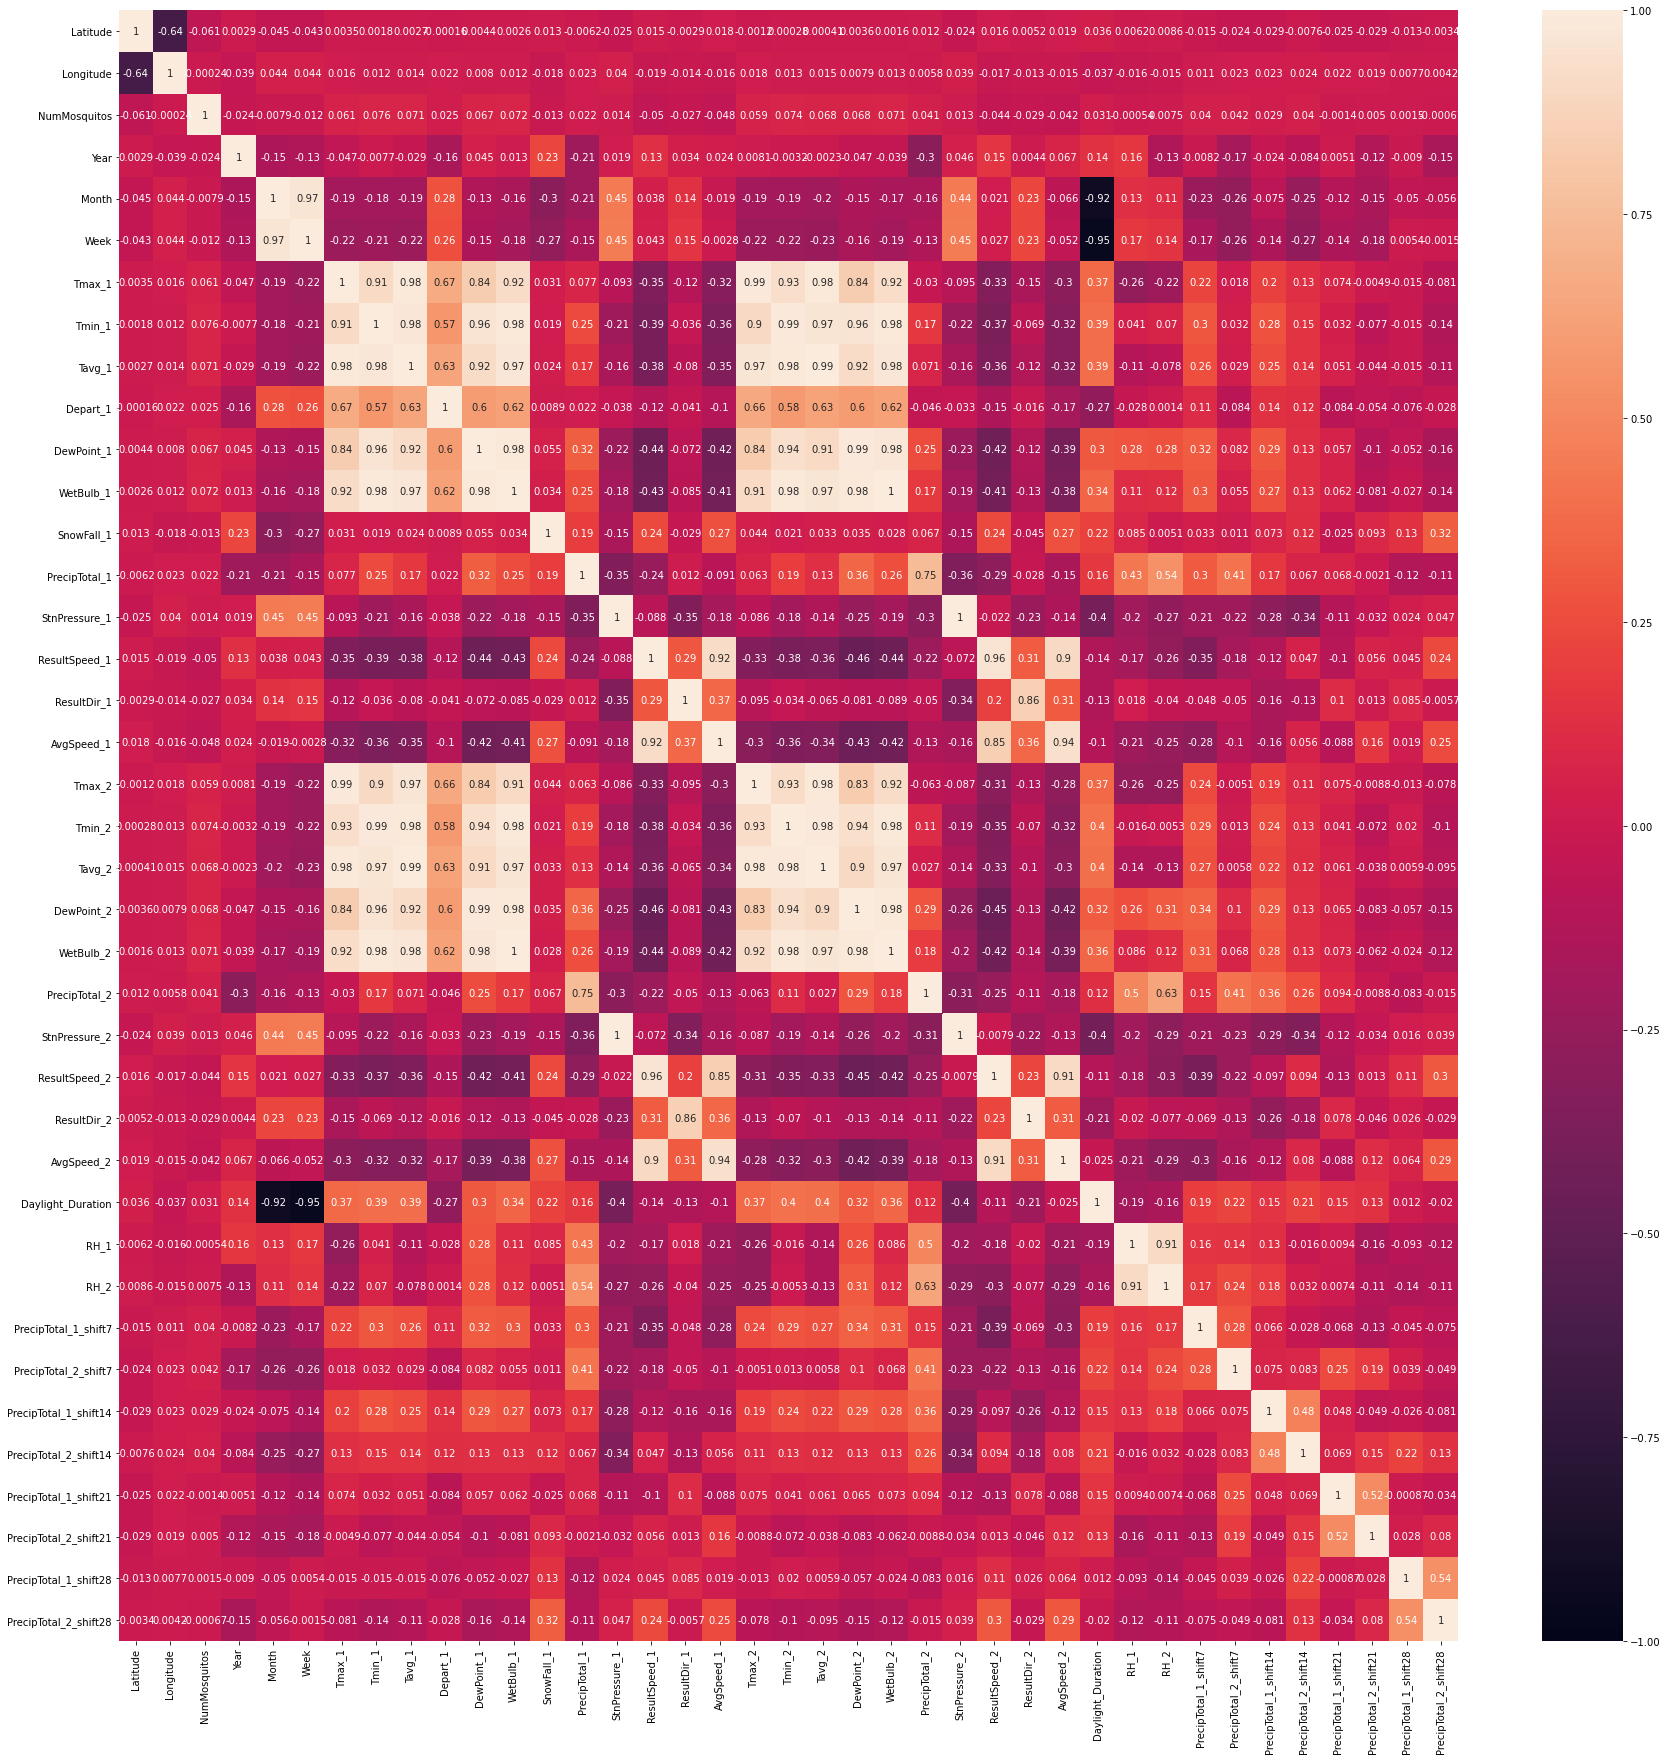

In [46]:
plt.figure(figsize=(30,30))
sns.heatmap(train_weather_weekly.corr(), annot=True, vmax=1, vmin=-1)

#### Plotting predictors vs WnvPresent

In [47]:
columnsOfInterest = ['Latitude', 'Longitude', 'Year', 'Month',
                     'Week', 'Tmax_1', 'Tmin_1', 'Tavg_1',
                     'Depart_1', 'DewPoint_1', 'WetBulb_1', 'SnowFall_1',
                     'PrecipTotal_1', 'StnPressure_1', 'ResultSpeed_1', 'ResultDir_1',
                     'AvgSpeed_1', 'Tmax_2', 'Tmin_2', 'Tavg_2',
                     'DewPoint_2', 'WetBulb_2', 'PrecipTotal_2', 'StnPressure_2',
                     'ResultSpeed_2', 'ResultDir_2', 'AvgSpeed_2', 'Daylight_Duration',
                     'RH_1', 'RH_2', 'PrecipTotal_1_shift7', 'PrecipTotal_2_shift7',
                     'PrecipTotal_1_shift14', 'PrecipTotal_2_shift14', 'PrecipTotal_1_shift21', 'PrecipTotal_2_shift21',
                     'PrecipTotal_1_shift28', 'PrecipTotal_2_shift28']

Text(0.5, 1.0, 'CULEX RESTUANS')

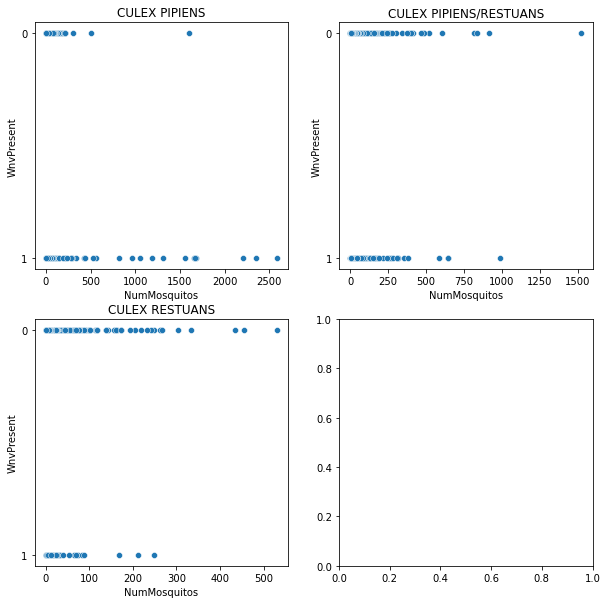

In [48]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
sns.scatterplot(x='NumMosquitos', y='WnvPresent', data=train_weather_weekly[train_weather_weekly['Species']=='CULEX PIPIENS'], ax=ax[0,0])
ax[0,0].set_title('CULEX PIPIENS')
sns.scatterplot(x='NumMosquitos', y='WnvPresent', data=train_weather_weekly[train_weather_weekly['Species']=='CULEX PIPIENS/RESTUANS'], ax=ax[0,1])
ax[0,1].set_title('CULEX PIPIENS/RESTUANS')
sns.scatterplot(x='NumMosquitos', y='WnvPresent', data=train_weather_weekly[train_weather_weekly['Species']=='CULEX RESTUANS'], ax=ax[1,0])
ax[1,0].set_title('CULEX RESTUANS')

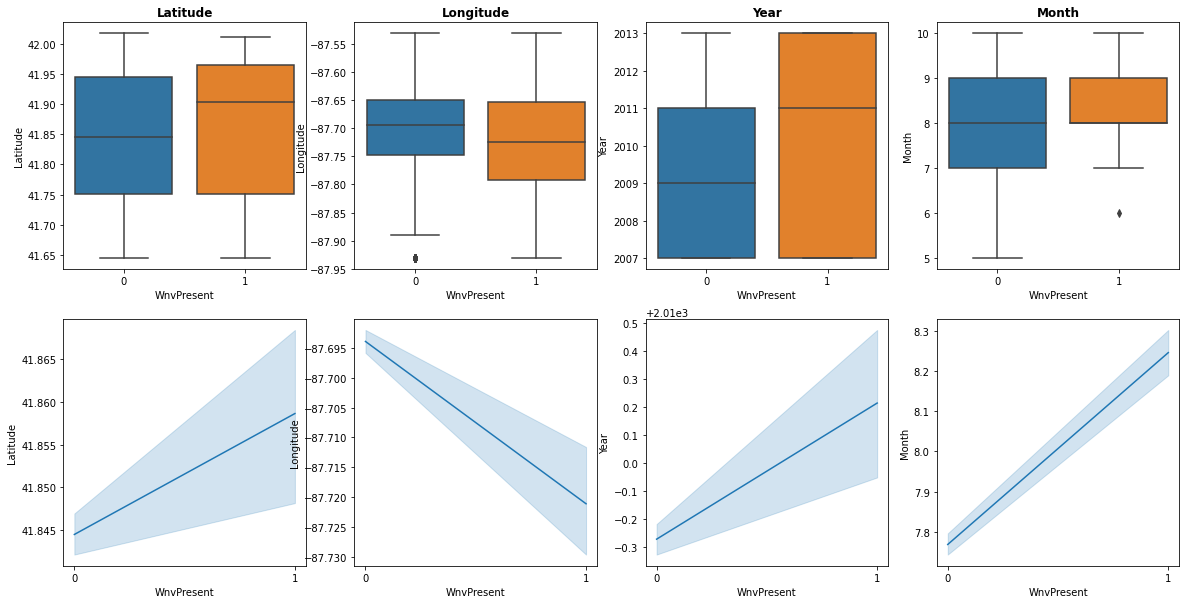

In [49]:
features = columnsOfInterest[0:4]
plot_4_boxplot_lineplot(train_weather_weekly, x_list=['WnvPresent']*4, y_list=features, plotTitle_list=features)

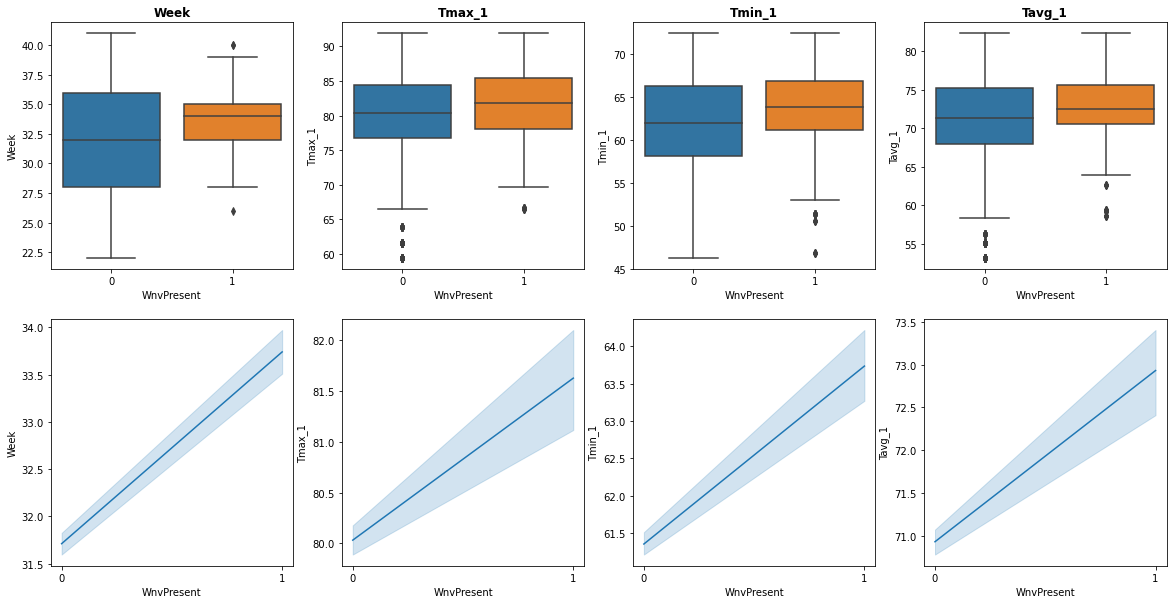

In [50]:
features = columnsOfInterest[4:8]
plot_4_boxplot_lineplot(train_weather_weekly, x_list=['WnvPresent']*4, y_list=features, plotTitle_list=features)

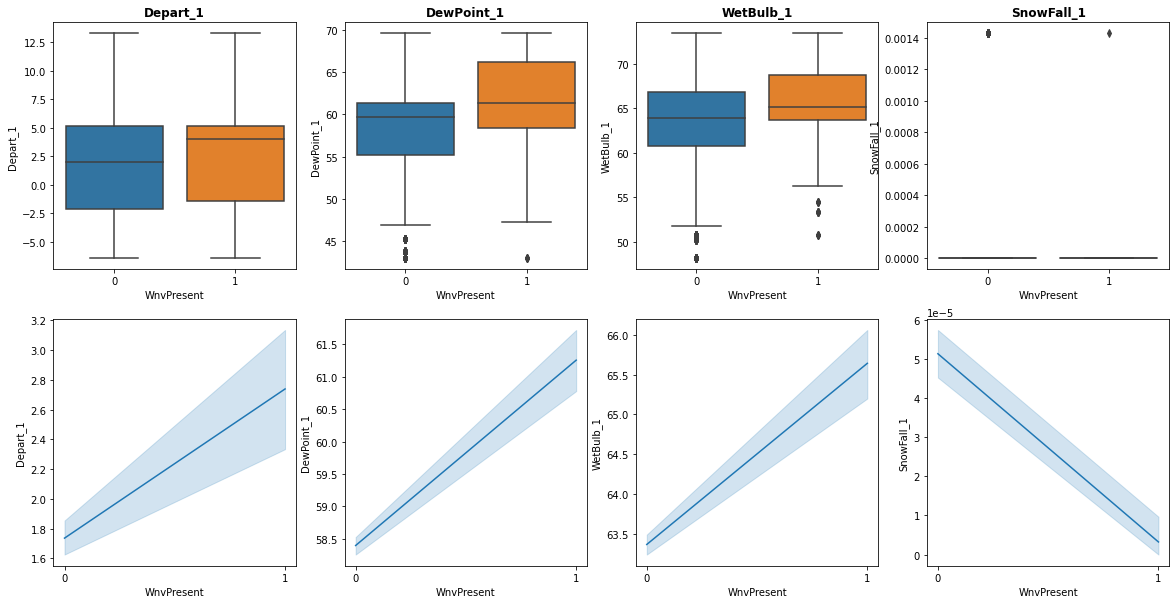

In [51]:
features = columnsOfInterest[8:12]
plot_4_boxplot_lineplot(train_weather_weekly, x_list=['WnvPresent']*4, y_list=features, plotTitle_list=features)

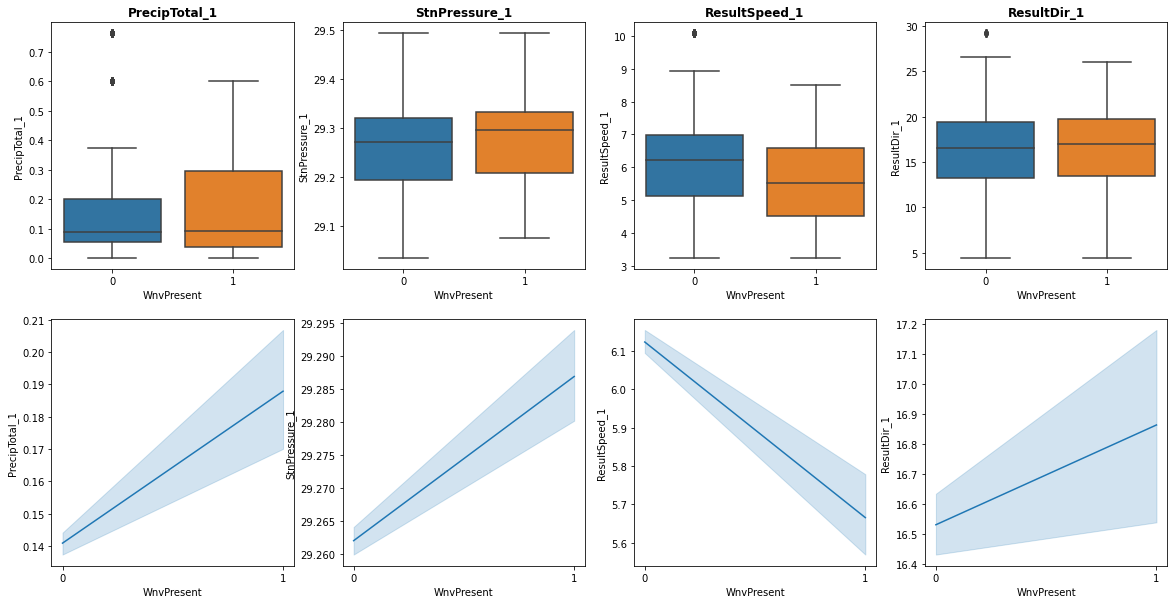

In [52]:
features = columnsOfInterest[12:16]
plot_4_boxplot_lineplot(train_weather_weekly, x_list=['WnvPresent']*4, y_list=features, plotTitle_list=features)

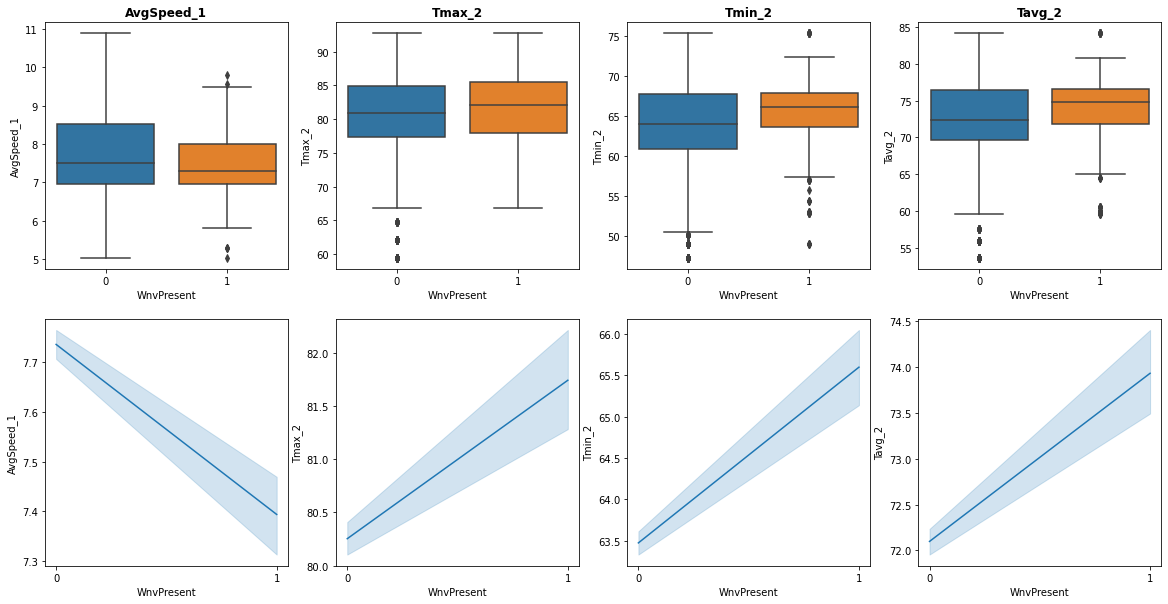

In [53]:
features = columnsOfInterest[16:20]
plot_4_boxplot_lineplot(train_weather_weekly, x_list=['WnvPresent']*4, y_list=features, plotTitle_list=features)

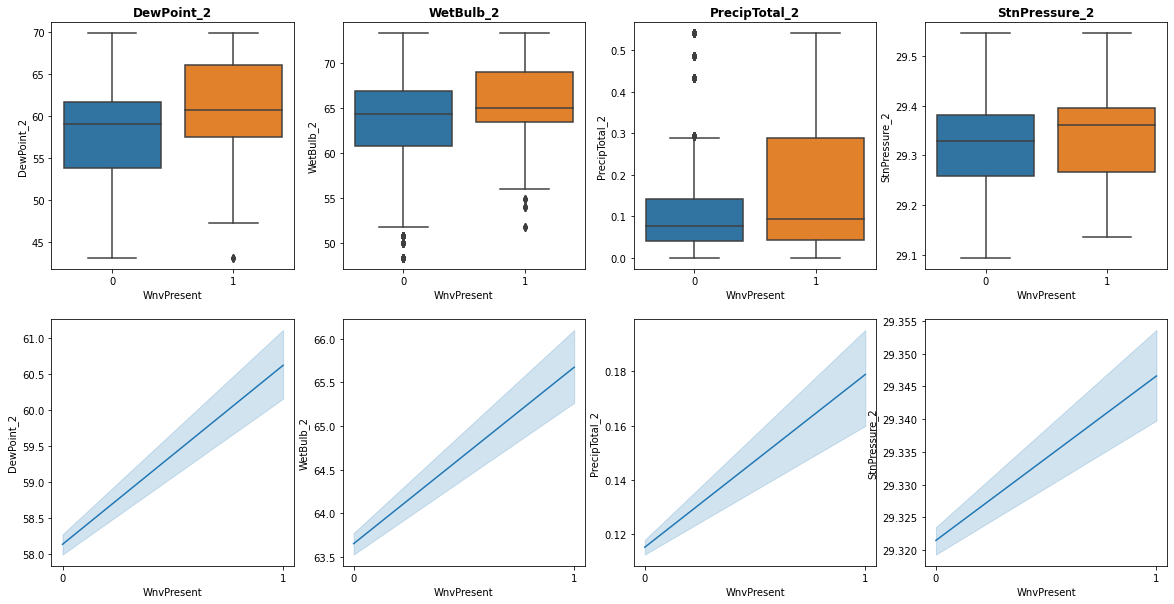

In [54]:
features = columnsOfInterest[20:24]
plot_4_boxplot_lineplot(train_weather_weekly, x_list=['WnvPresent']*4, y_list=features, plotTitle_list=features)

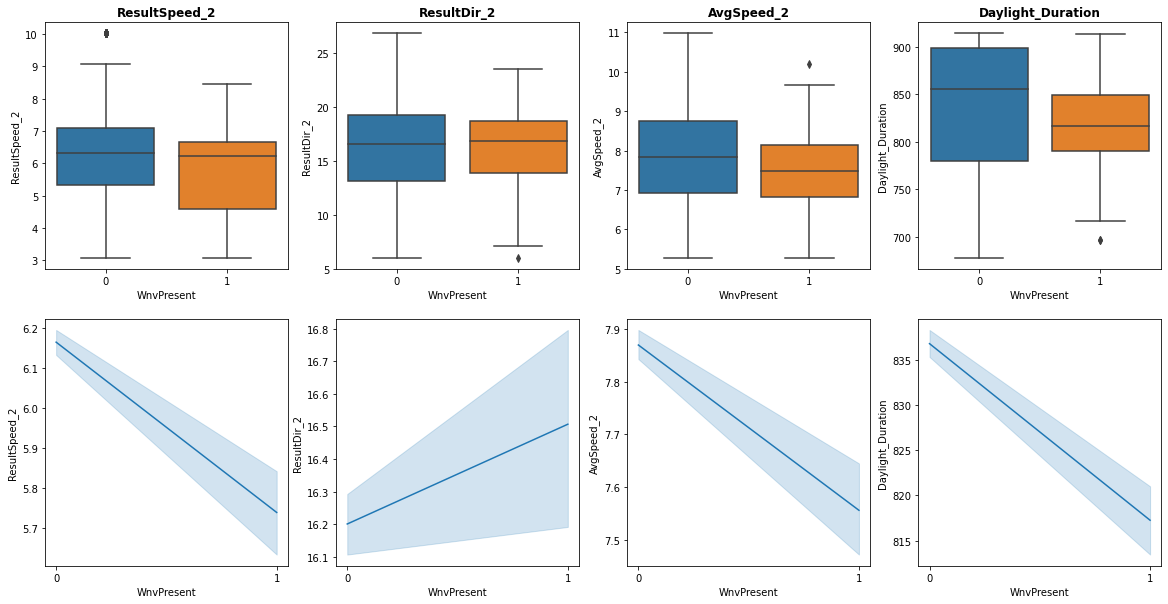

In [55]:
features = columnsOfInterest[24:28]
plot_4_boxplot_lineplot(train_weather_weekly, x_list=['WnvPresent']*4, y_list=features, plotTitle_list=features)

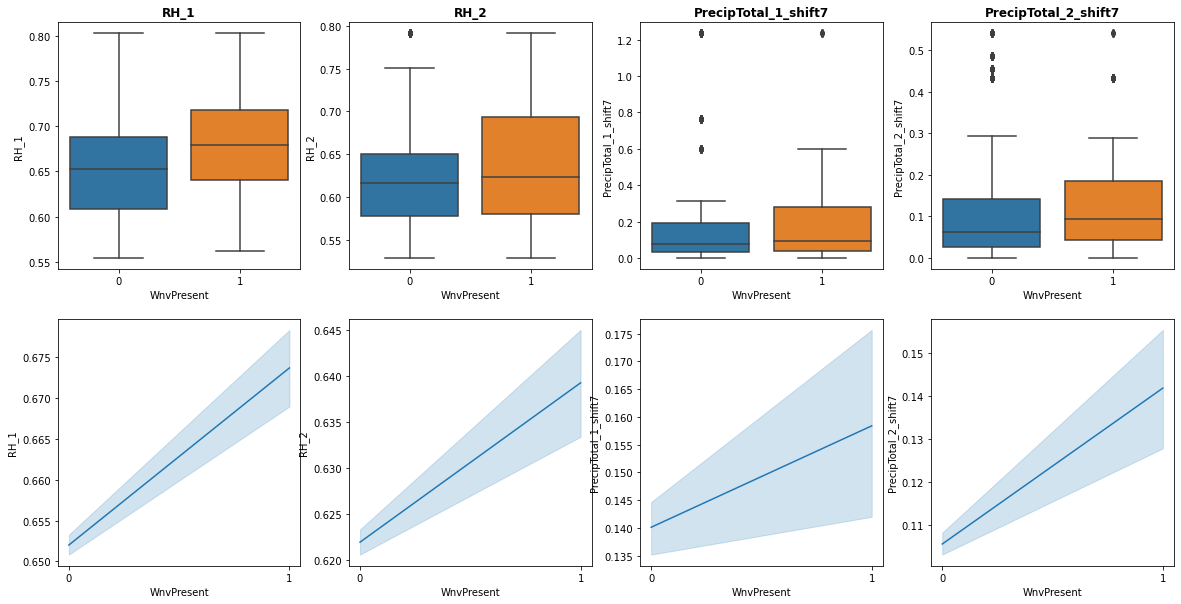

In [56]:
features = columnsOfInterest[28:32]
plot_4_boxplot_lineplot(train_weather_weekly, x_list=['WnvPresent']*4, y_list=features, plotTitle_list=features)

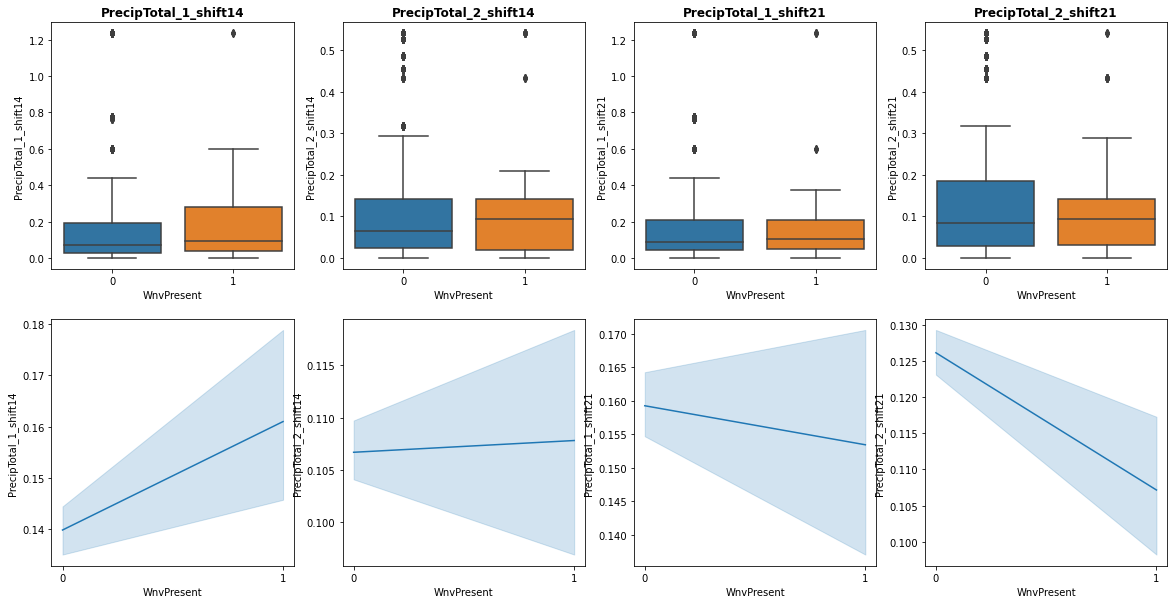

In [57]:
features = columnsOfInterest[32:36]
plot_4_boxplot_lineplot(train_weather_weekly, x_list=['WnvPresent']*4, y_list=features, plotTitle_list=features)

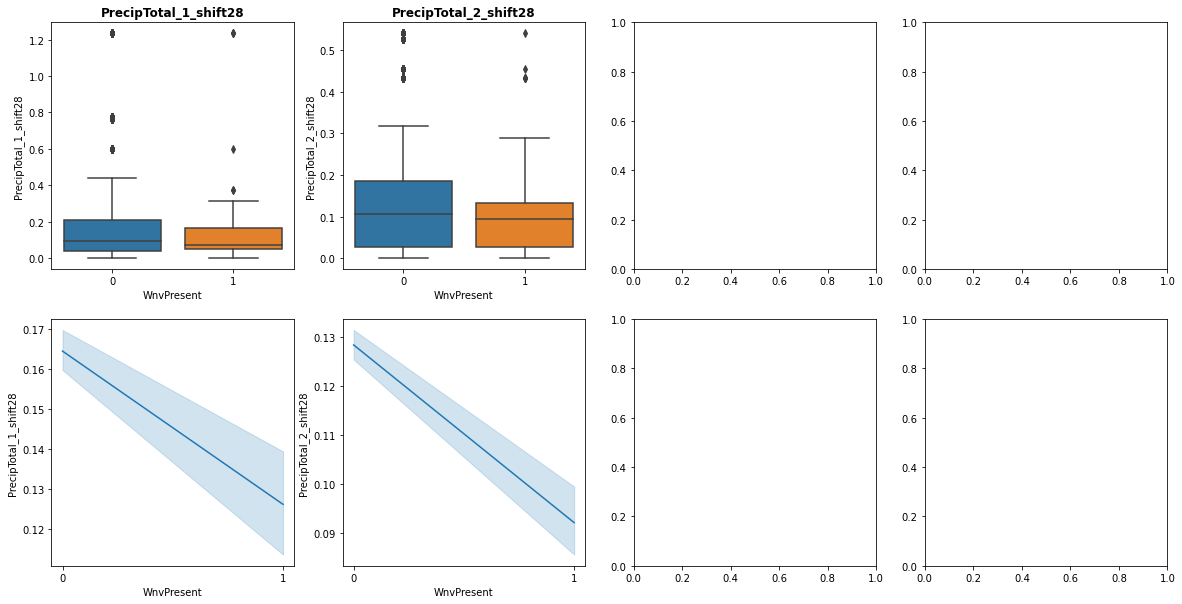

In [58]:
features = columnsOfInterest[36:38]
plot_4_boxplot_lineplot(train_weather_weekly, x_list=['WnvPresent']*2, y_list=features, plotTitle_list=features)

### What affects number of mosquitoes?

#### How does the average number of mosquitoes varies by the year?
- Culex Pipiens had a significantly higher average in 2007. However by 2009, the average drastically fell before increasing again in 2011 to 2013.
- Culex Pipiens/Restuans average number of mosquitoes had remained relatively stable across the years.
- Culex Restuans average number of mosquitoes had been increasing steadily each year.
- Culex Erraticus only appeared in 2013.
- Remaining species average had been low and relatively stable.

<AxesSubplot:xlabel='Year', ylabel='NumMosquitos'>

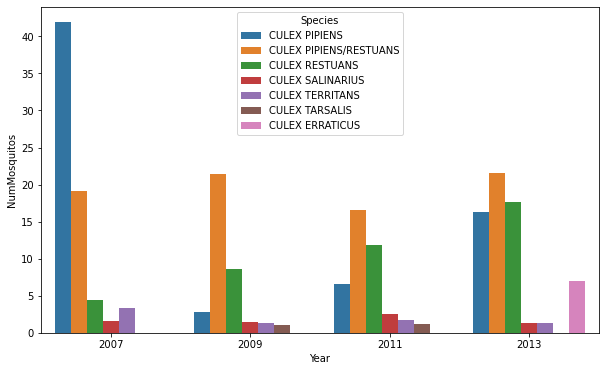

In [59]:
plt.figure(figsize=(10,6))
sns.barplot(x='Year', y='NumMosquitos', hue='Species', data=train_weather_weekly.groupby(['Year', 'Species']).mean().reset_index())

#### How does average number of mosquitoes varies by the week for each species?
Culex Pipiens has the highest average number and spike of mosquitoes among the 7 species, followed by Culex Pipiens/Restuans and Culex Restuans. The remaining species average number generally remain relatively stable and low during these period.

<AxesSubplot:xlabel='Species_Week', ylabel='NumMosquitos'>

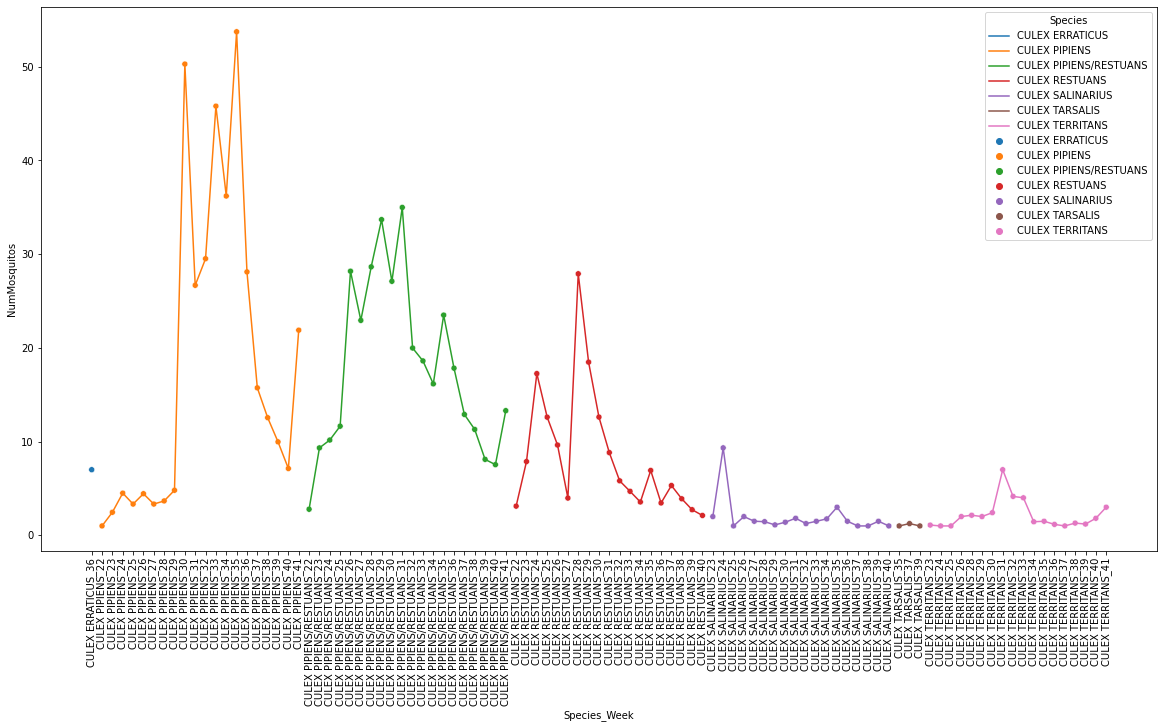

In [60]:
temp = train_weather_weekly.groupby(by=['Species', 'Week'])['NumMosquitos'].mean().reset_index()
temp['Species_Week'] = temp['Species'] + "_" + temp['Week'].astype('str')
temp.sort_values(by=['Species', 'Week'])
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
sns.lineplot(y='NumMosquitos', x='Species_Week', data=temp, hue='Species')
sns.scatterplot(y='NumMosquitos', x='Species_Week', data=temp, hue='Species', sizes=20)

#### How does the amount of precipitation affected the number of mosquitoes?
Different year seems to require different lag duration. For example for 2007, 0 lag in total precipitation seems to be match the spike in number of mosquitoes while for 2009, it seems like 21 days lag seems like a better match with the spike for number of mosquitoes.

Text(0, 0.5, 'Total Precipitation')

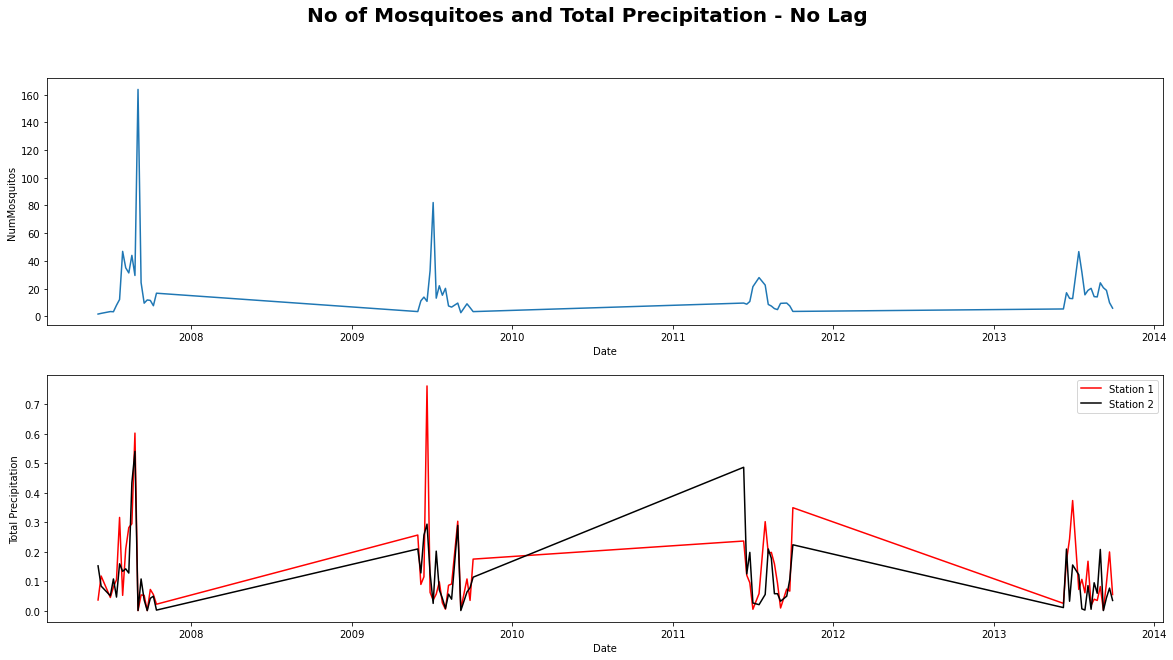

In [61]:
# Num of Mosquitoes vs Total Precipitation
fig, ax = plt.subplots(2,1, figsize=(20,10))
sns.lineplot(x=train_weather_weekly.index, y=train_weather_weekly['NumMosquitos'], err_style=None,ax=ax[0])
sns.lineplot(x=train_weather_weekly.index, y=train_weather_weekly['PrecipTotal_1'], err_style=None, ax=ax[1], color='r', label='Station 1')
sns.lineplot(x=train_weather_weekly.index, y=train_weather_weekly['PrecipTotal_2'], err_style=None, ax=ax[1], color='black', label='Station 2')
plt.suptitle('No of Mosquitoes and Total Precipitation - No Lag', fontweight='bold', fontsize=20)
ax[1].set_ylabel('Total Precipitation')

Text(0, 0.5, 'Total Precipitation')

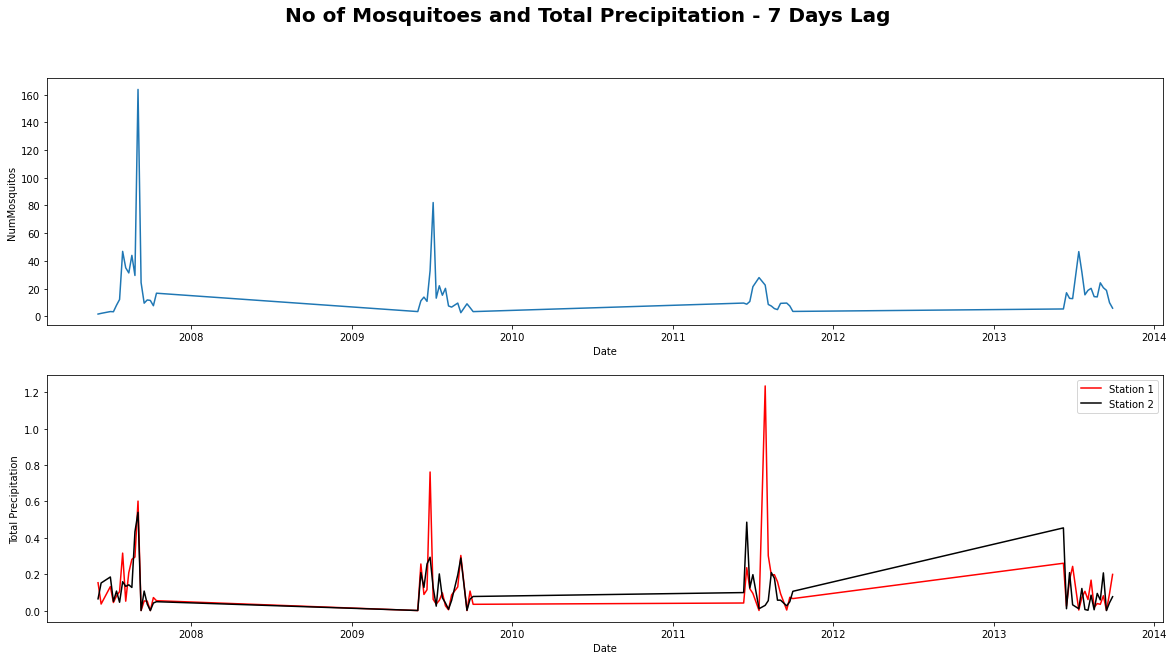

In [62]:
# Num of Mosquitoes vs Total Precipitation From 7 Days Ago
fig, ax = plt.subplots(2,1, figsize=(20,10))
sns.lineplot(x=train_weather_weekly.index, y=train_weather_weekly['NumMosquitos'], err_style=None,ax=ax[0])
sns.lineplot(x=train_weather_weekly.index, y=train_weather_weekly['PrecipTotal_1_shift7'], err_style=None, ax=ax[1], color='r', label='Station 1')
sns.lineplot(x=train_weather_weekly.index, y=train_weather_weekly['PrecipTotal_2_shift7'], err_style=None, ax=ax[1], color='black', label='Station 2')
plt.suptitle('No of Mosquitoes and Total Precipitation - 7 Days Lag', fontweight='bold', fontsize=20)
ax[1].set_ylabel('Total Precipitation')

Text(0, 0.5, 'Total Precipitation')

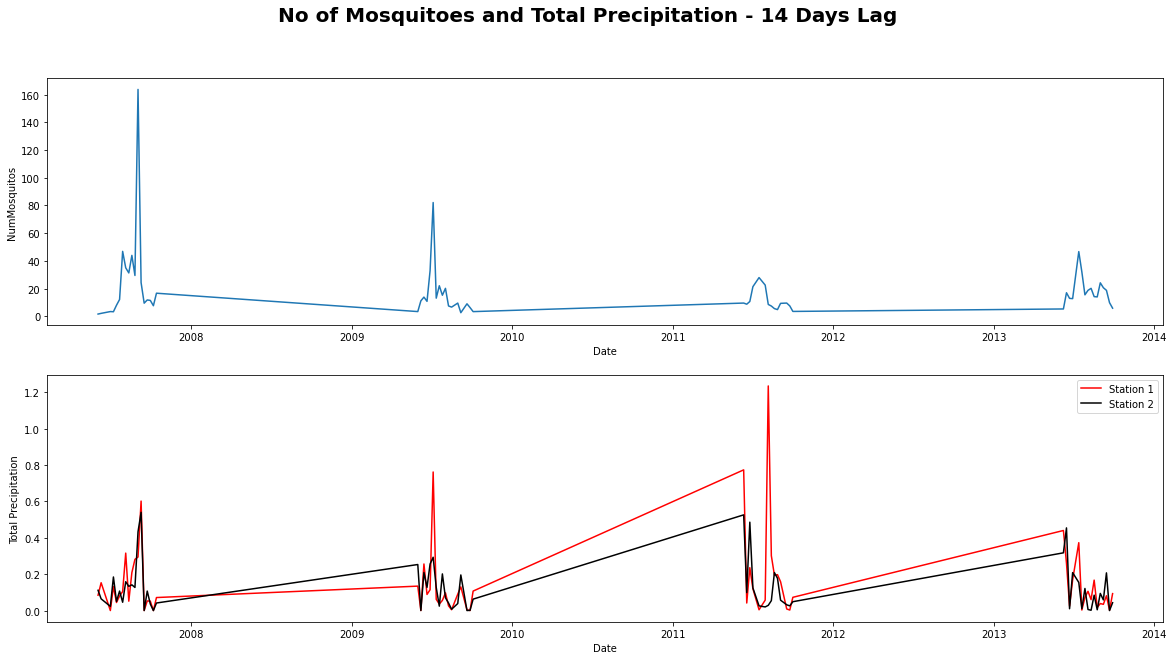

In [63]:
# Num of Mosquitoes vs Total Precipitation From 14 Days Ago
fig, ax = plt.subplots(2,1, figsize=(20,10))
sns.lineplot(x=train_weather_weekly.index, y=train_weather_weekly['NumMosquitos'], err_style=None,ax=ax[0])
sns.lineplot(x=train_weather_weekly.index, y=train_weather_weekly['PrecipTotal_1_shift14'], err_style=None, ax=ax[1], color='r', label='Station 1')
sns.lineplot(x=train_weather_weekly.index, y=train_weather_weekly['PrecipTotal_2_shift14'], err_style=None, ax=ax[1], color='black', label='Station 2')
plt.suptitle('No of Mosquitoes and Total Precipitation - 14 Days Lag', fontweight='bold', fontsize=20)
ax[1].set_ylabel('Total Precipitation')

Text(0, 0.5, 'Total Precipitation')

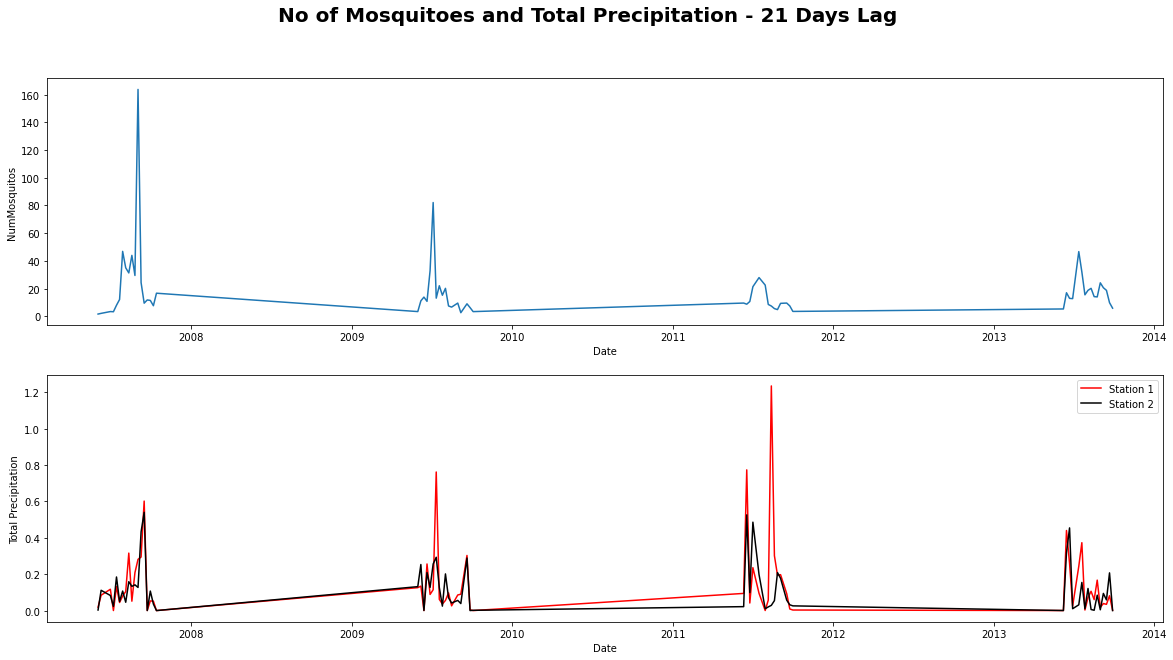

In [64]:
# Num of Mosquitoes vs Total Precipitation From 21 Days Ago
fig, ax = plt.subplots(2,1, figsize=(20,10))
sns.lineplot(x=train_weather_weekly.index, y=train_weather_weekly['NumMosquitos'], err_style=None,ax=ax[0])
sns.lineplot(x=train_weather_weekly.index, y=train_weather_weekly['PrecipTotal_1_shift21'], err_style=None, ax=ax[1], color='r', label='Station 1')
sns.lineplot(x=train_weather_weekly.index, y=train_weather_weekly['PrecipTotal_2_shift21'], err_style=None, ax=ax[1], color='black', label='Station 2')
plt.suptitle('No of Mosquitoes and Total Precipitation - 21 Days Lag', fontweight='bold', fontsize=20)
ax[1].set_ylabel('Total Precipitation')

Text(0, 0.5, 'Total Precipitation')

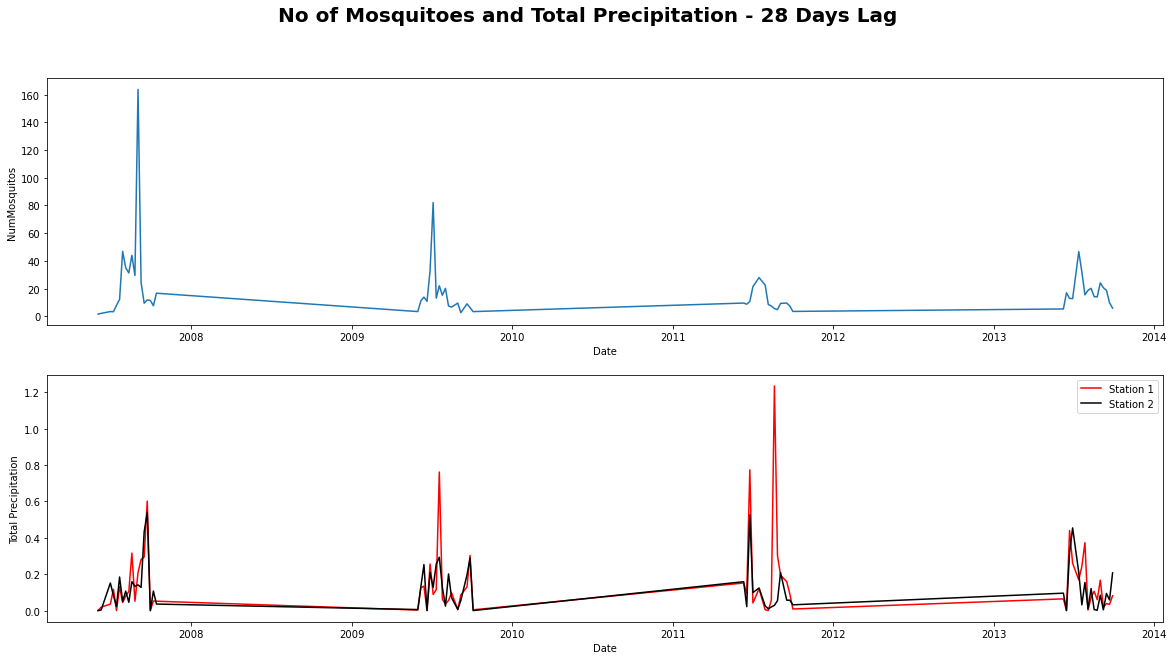

In [65]:
# Num of Mosquitoes vs Total Precipitation From 28 Days Ago
fig, ax = plt.subplots(2,1, figsize=(20,10))
sns.lineplot(x=train_weather_weekly.index, y=train_weather_weekly['NumMosquitos'], err_style=None,ax=ax[0])
sns.lineplot(x=train_weather_weekly.index, y=train_weather_weekly['PrecipTotal_1_shift28'], err_style=None, ax=ax[1], color='r', label='Station 1')
sns.lineplot(x=train_weather_weekly.index, y=train_weather_weekly['PrecipTotal_2_shift28'], err_style=None, ax=ax[1], color='black', label='Station 2')
plt.suptitle('No of Mosquitoes and Total Precipitation - 28 Days Lag', fontweight='bold', fontsize=20)
ax[1].set_ylabel('Total Precipitation')

#### How does humidity affect the number of mosquitoes?
While theoretically, higher humidity should encourage more mosquitoes and increase their activities, however, from the trend below, it does not seem to be the case.

Text(0, 0.5, 'Relative Humidity')

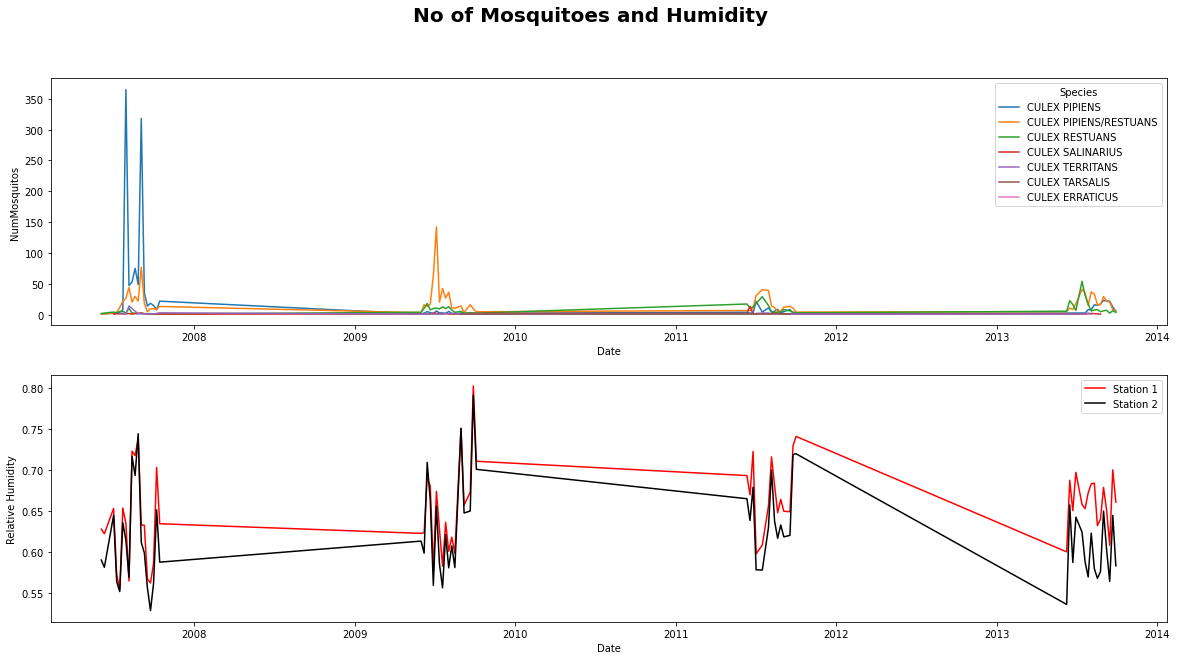

In [66]:
# Num of Mosquitoes vs Total Precipitation From 28 Days Ago
fig, ax = plt.subplots(2,1, figsize=(20,10))
sns.lineplot(x=train_weather_weekly.index, y=train_weather_weekly['NumMosquitos'], data=train_weather_weekly, err_style=None,ax=ax[0], hue='Species')
sns.lineplot(x=train_weather_weekly.index, y=train_weather_weekly['RH_1'], err_style=None, ax=ax[1], color='r', label='Station 1')
sns.lineplot(x=train_weather_weekly.index, y=train_weather_weekly['RH_2'], err_style=None, ax=ax[1], color='black', label='Station 2')
plt.suptitle('No of Mosquitoes and Humidity', fontweight='bold', fontsize=20)
ax[1].set_ylabel('Relative Humidity')

#### Does Average Temp Falling Below 50°F Results in Less Mosquitoes?

When there is at least 1 day in a week that has average temperature falling below 50°F, the number of mosquitoes are lower with less outliers as compared to using minimum temperature.

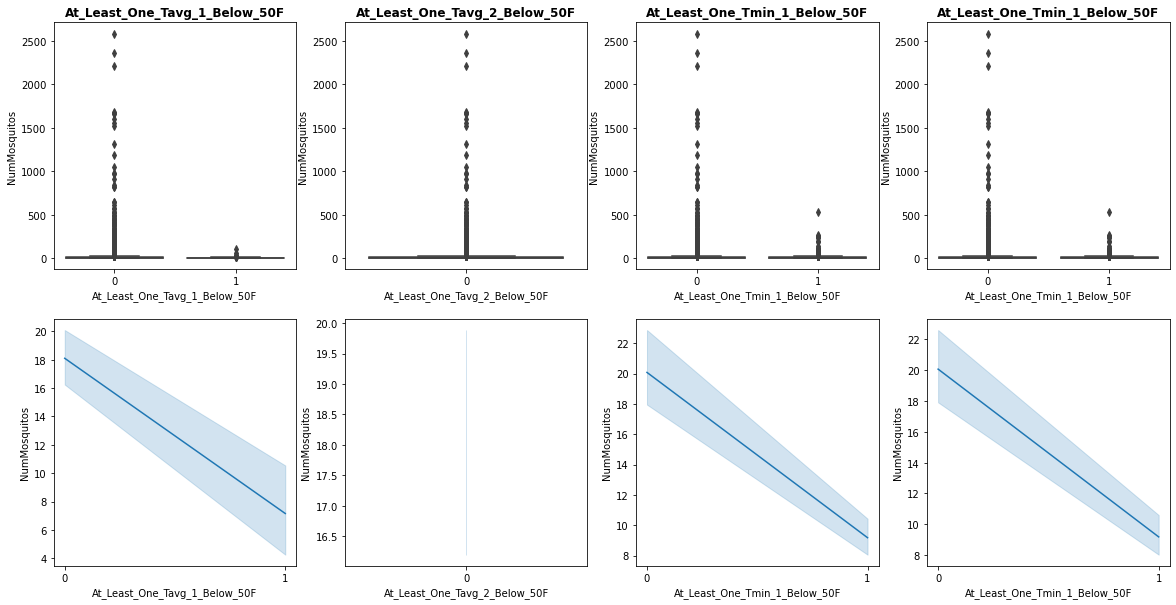

In [67]:
predictors = ['At_Least_One_Tavg_1_Below_50F',
              'At_Least_One_Tavg_2_Below_50F',
              'At_Least_One_Tmin_1_Below_50F',
              'At_Least_One_Tmin_1_Below_50F']
plot_4_boxplot_lineplot(train_weather_weekly, x_list=predictors, y_list=['NumMosquitos']*4,
                      plotTitle_list=predictors)

#### Is number of mosquitos affected by other continous predictors?
No predictor has linear relationship with the number of mosquitoes.

In [68]:
columnsOfInterest = ['Latitude', 'Longitude', 'Year', 'Month',
                     'Week', 'Tmax_1', 'Tmin_1', 'Tavg_1',
                     'Depart_1', 'DewPoint_1', 'WetBulb_1', 'SnowFall_1',
                     'PrecipTotal_1', 'StnPressure_1', 'ResultSpeed_1', 'ResultDir_1',
                     'AvgSpeed_1', 'Tmax_2', 'Tmin_2', 'Tavg_2',
                     'DewPoint_2', 'WetBulb_2', 'PrecipTotal_2', 'StnPressure_2',
                     'ResultSpeed_2', 'ResultDir_2', 'AvgSpeed_2', 'Daylight_Duration',
                     'RH_1', 'RH_2', 'PrecipTotal_1_shift7', 'PrecipTotal_2_shift7',
                     'PrecipTotal_1_shift14', 'PrecipTotal_2_shift14', 'PrecipTotal_1_shift21', 'PrecipTotal_2_shift21',
                     'PrecipTotal_1_shift28', 'PrecipTotal_2_shift28']

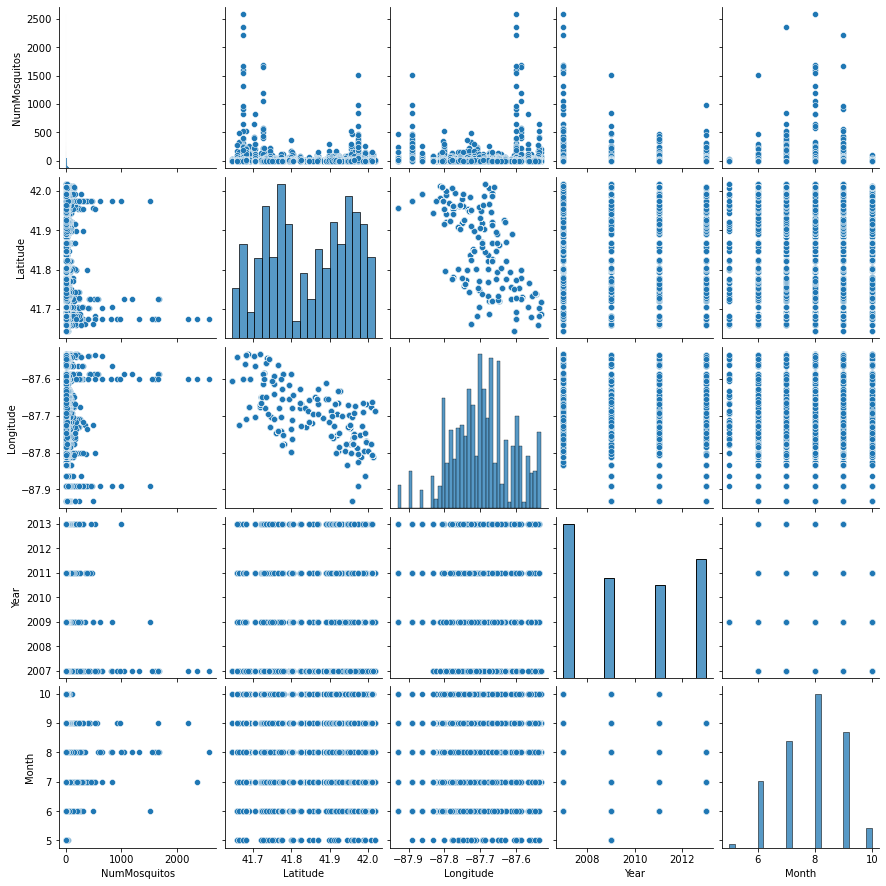

In [69]:
predictorsOfInterest = ['NumMosquitos']+columnsOfInterest[0:4]
sns.pairplot(train_weather_weekly[predictorsOfInterest])

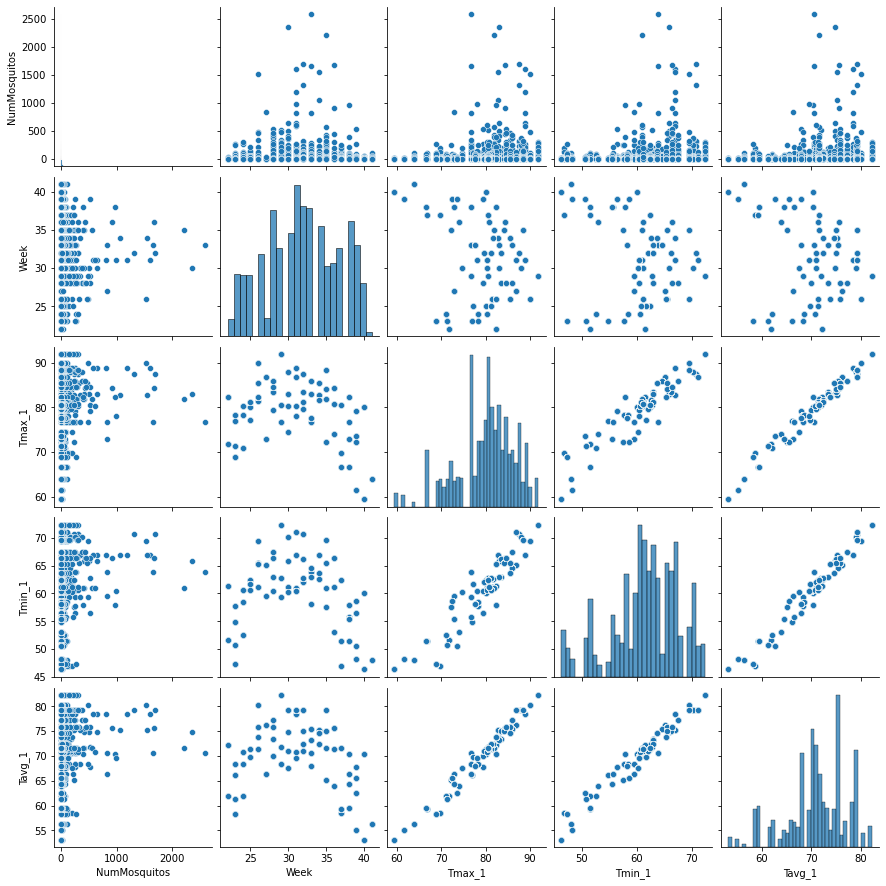

In [70]:
predictorsOfInterest = ['NumMosquitos']+columnsOfInterest[4:8]
sns.pairplot(train_weather_weekly[predictorsOfInterest])

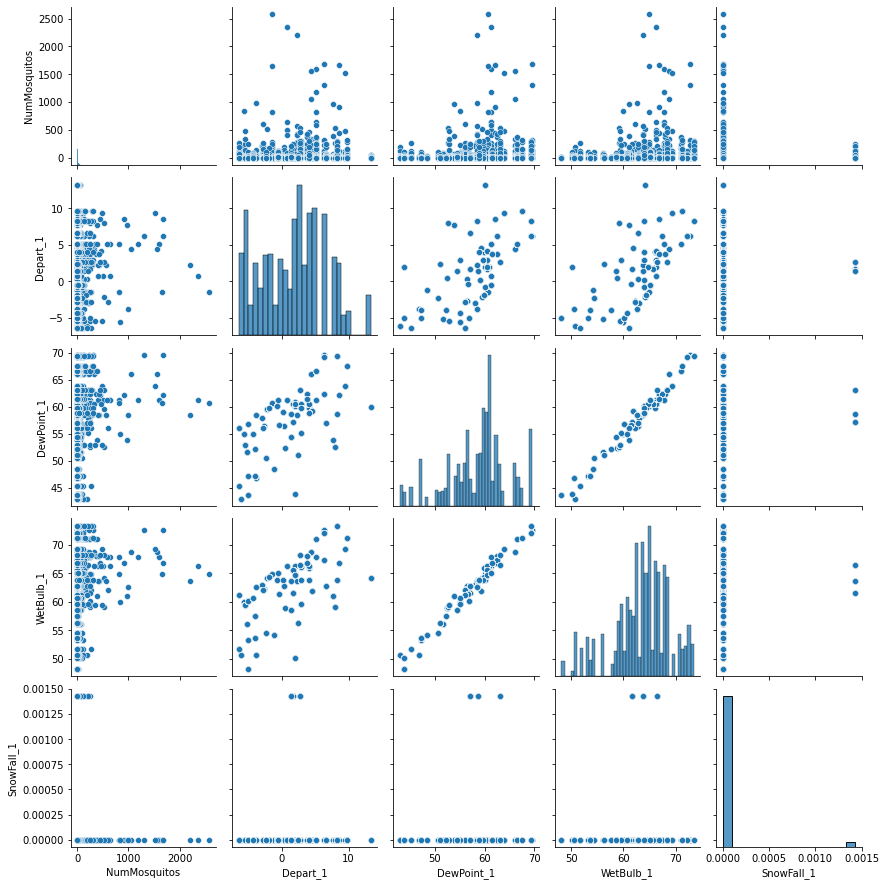

In [71]:
predictorsOfInterest = ['NumMosquitos']+columnsOfInterest[8:12]
sns.pairplot(train_weather_weekly[predictorsOfInterest])

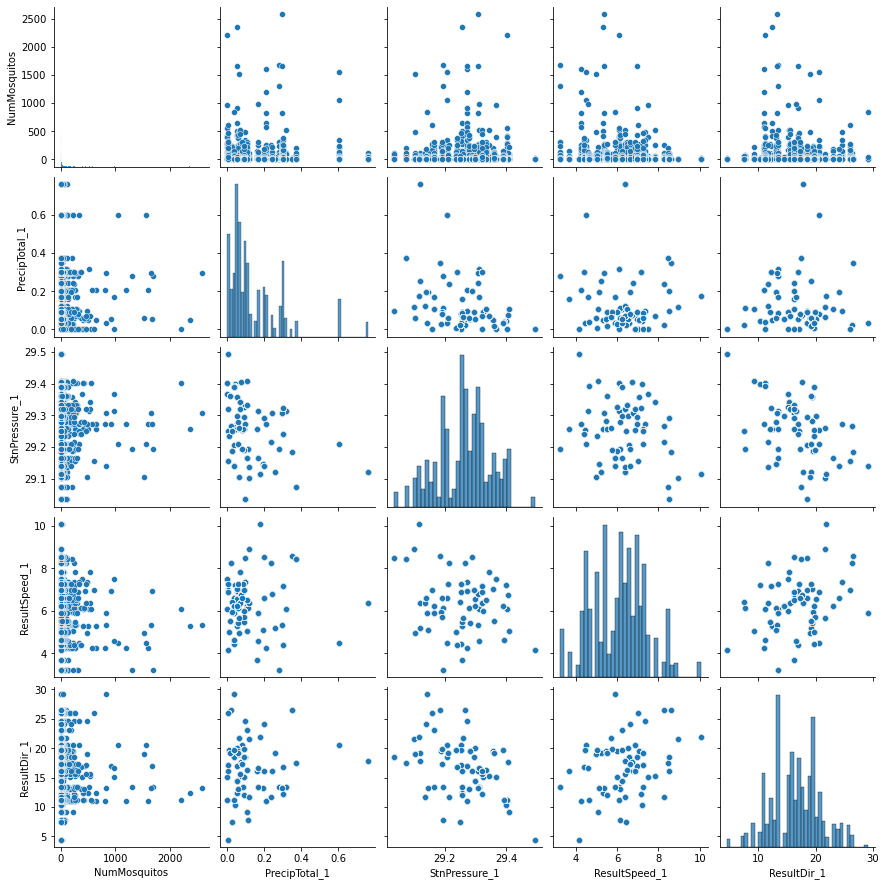

In [72]:
predictorsOfInterest = ['NumMosquitos']+columnsOfInterest[12:16]
sns.pairplot(train_weather_weekly[predictorsOfInterest])

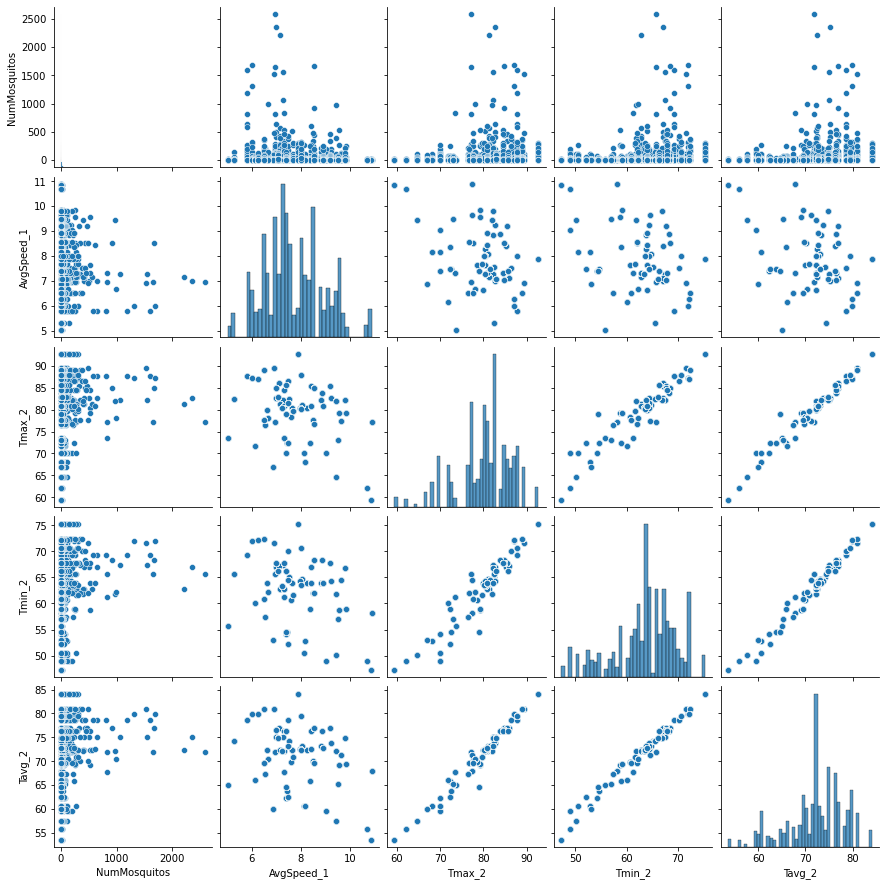

In [73]:
predictorsOfInterest = ['NumMosquitos']+columnsOfInterest[16:20]
sns.pairplot(train_weather_weekly[predictorsOfInterest])

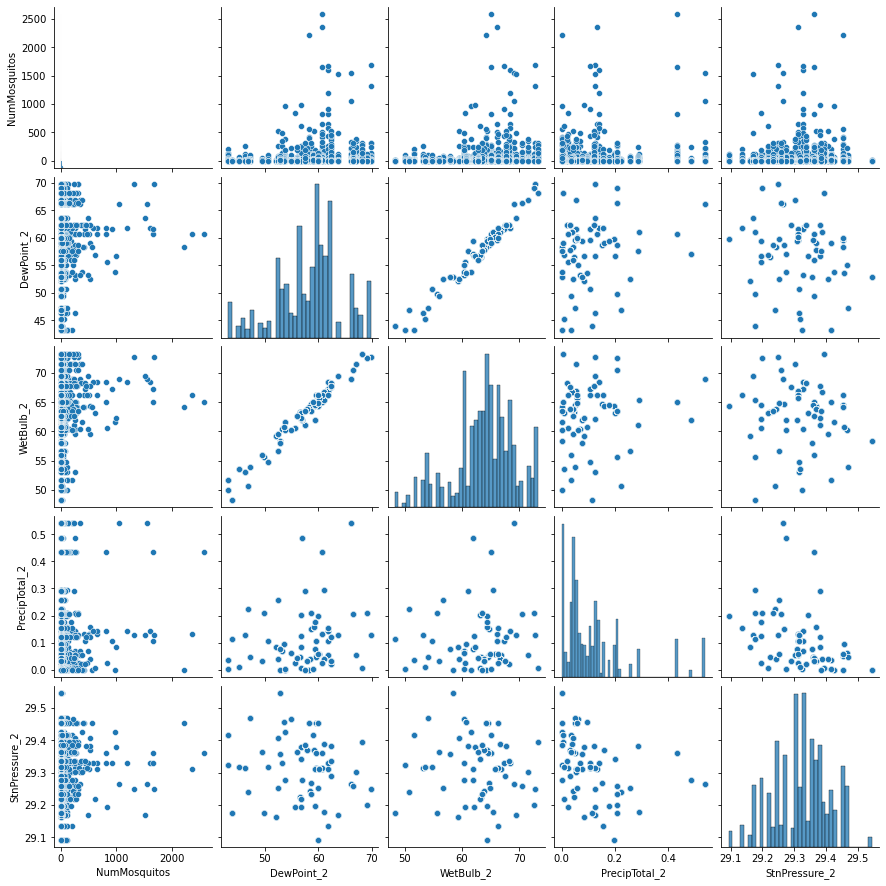

In [74]:
predictorsOfInterest = ['NumMosquitos']+columnsOfInterest[20:24]
sns.pairplot(train_weather_weekly[predictorsOfInterest])

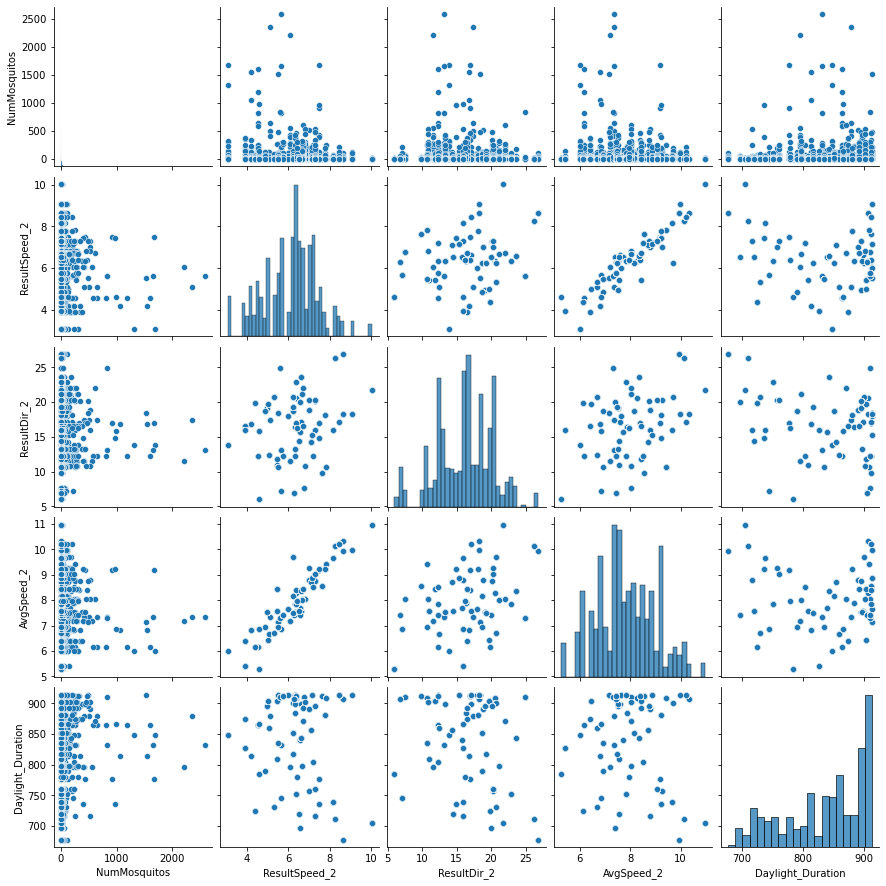

In [75]:
predictorsOfInterest = ['NumMosquitos']+columnsOfInterest[24:28]
sns.pairplot(train_weather_weekly[predictorsOfInterest])

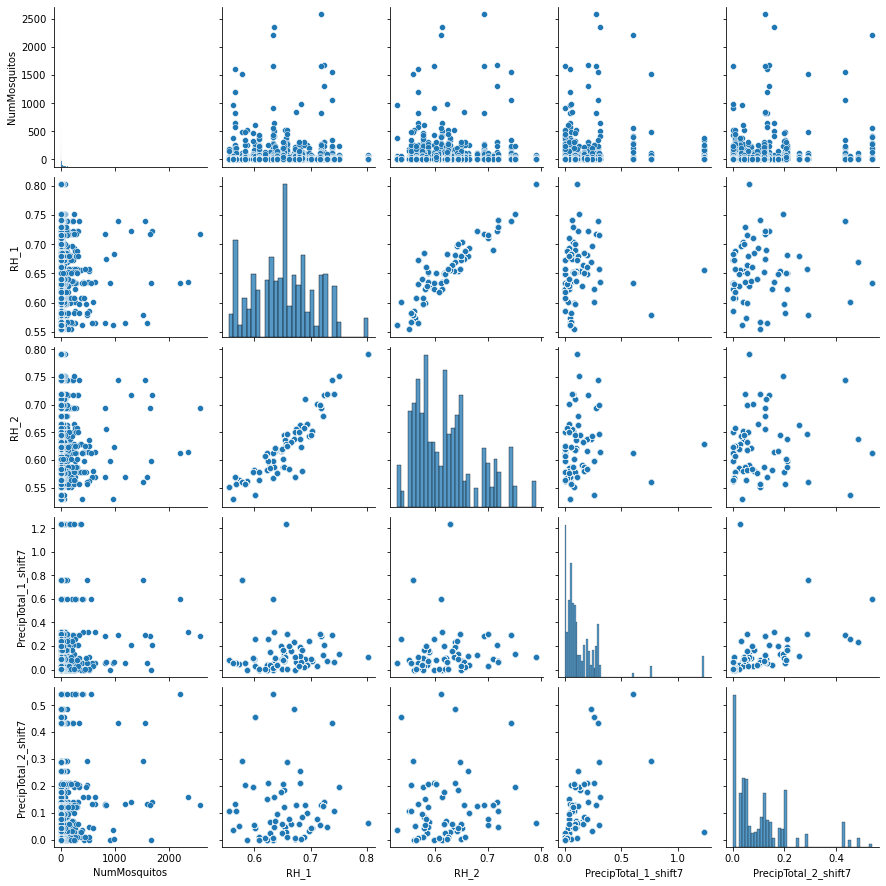

In [76]:
predictorsOfInterest = ['NumMosquitos']+columnsOfInterest[28:32]
sns.pairplot(train_weather_weekly[predictorsOfInterest])

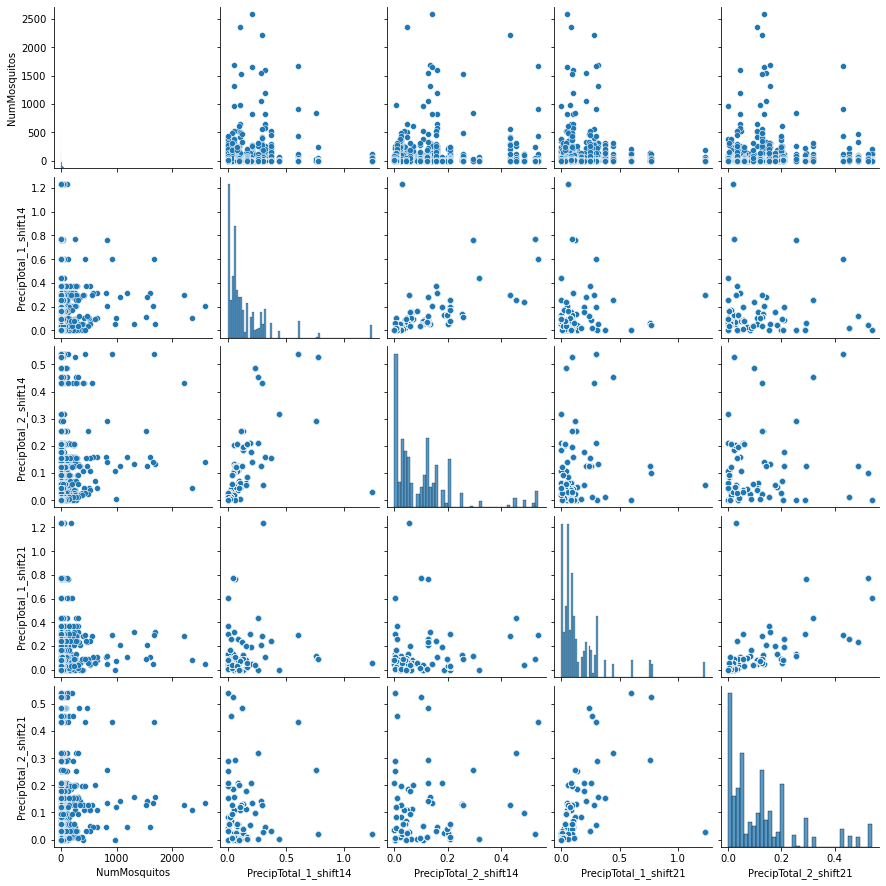

In [77]:
predictorsOfInterest = ['NumMosquitos']+columnsOfInterest[32:36]
sns.pairplot(train_weather_weekly[predictorsOfInterest])

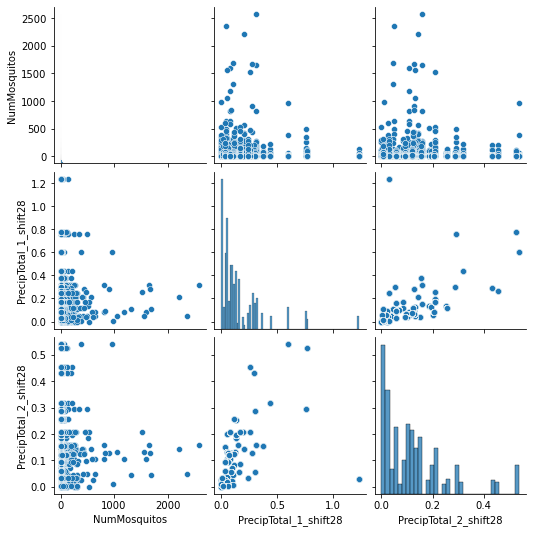

In [78]:
predictorsOfInterest = ['NumMosquitos']+columnsOfInterest[36:38]
sns.pairplot(train_weather_weekly[predictorsOfInterest])

In [79]:
columnsOfInterest = ['At_Least_One_Wet_Weather_1',
                     'At_Least_One_Wet_Weather_2',
                     'At_Least_One_Wet_Weather_1_shift7',
                     'At_Least_One_Wet_Weather_2_shift7',
                     'At_Least_One_Wet_Weather_1_shift14',
                     'At_Least_One_Wet_Weather_2_shift14',
                     'At_Least_One_Wet_Weather_1_shift21',
                     'At_Least_One_Wet_Weather_2_shift21',
                     'At_Least_One_Wet_Weather_1_shift28',
                     'At_Least_One_Wet_Weather_2_shift28']

#### How having at least 1 wet weather affects the number of mosquitoes?
In general, it seems that when data is not offset, having at least 1 wet weather caused the number of mosquitoes to decrease. However when data is offset by 1 week to 3 weeks, the trend reversed and more mosquitoes started appearing especially when it is offset by 2 to 3 weeks. When offset by 4 weeks, the result is mixed between station 1 and 2.

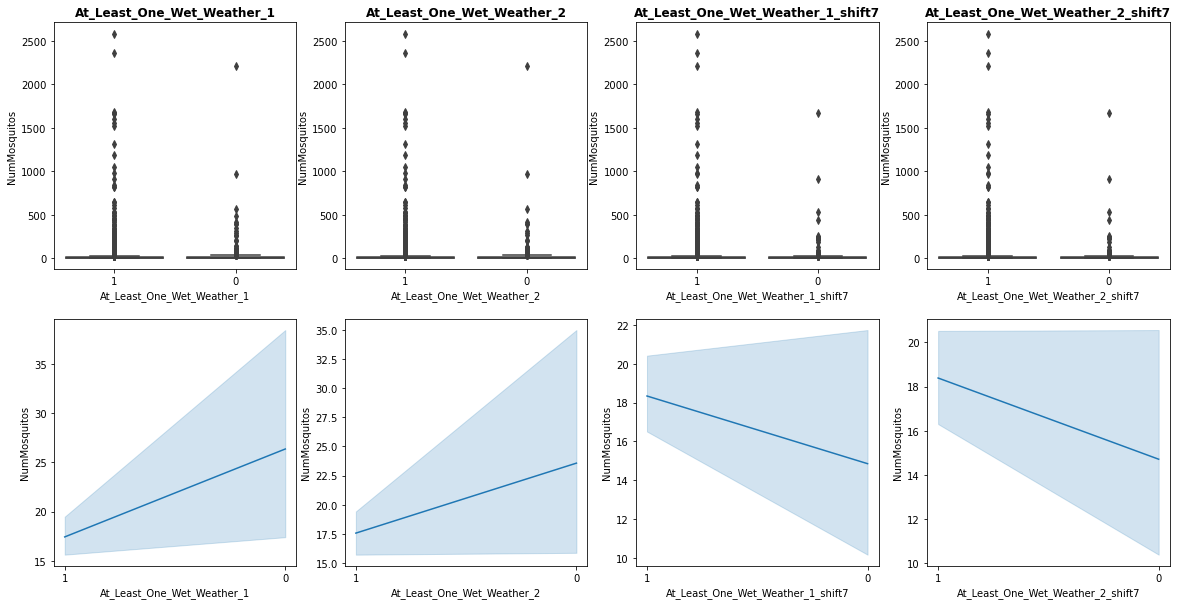

In [80]:
predictors = columnsOfInterest[0:4]
plot_4_boxplot_lineplot(train_weather_weekly, x_list=predictors, y_list=['NumMosquitos']*4,
                      plotTitle_list=predictors)

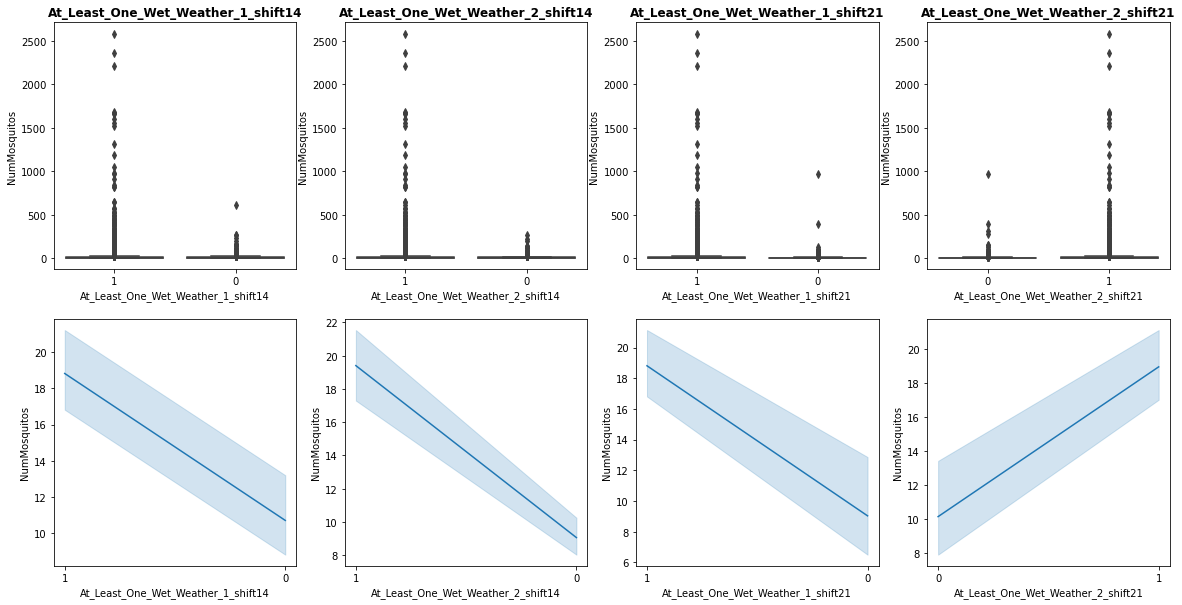

In [81]:
predictors = columnsOfInterest[4:8]
plot_4_boxplot_lineplot(train_weather_weekly, x_list=predictors, y_list=['NumMosquitos']*4,
                      plotTitle_list=predictors)

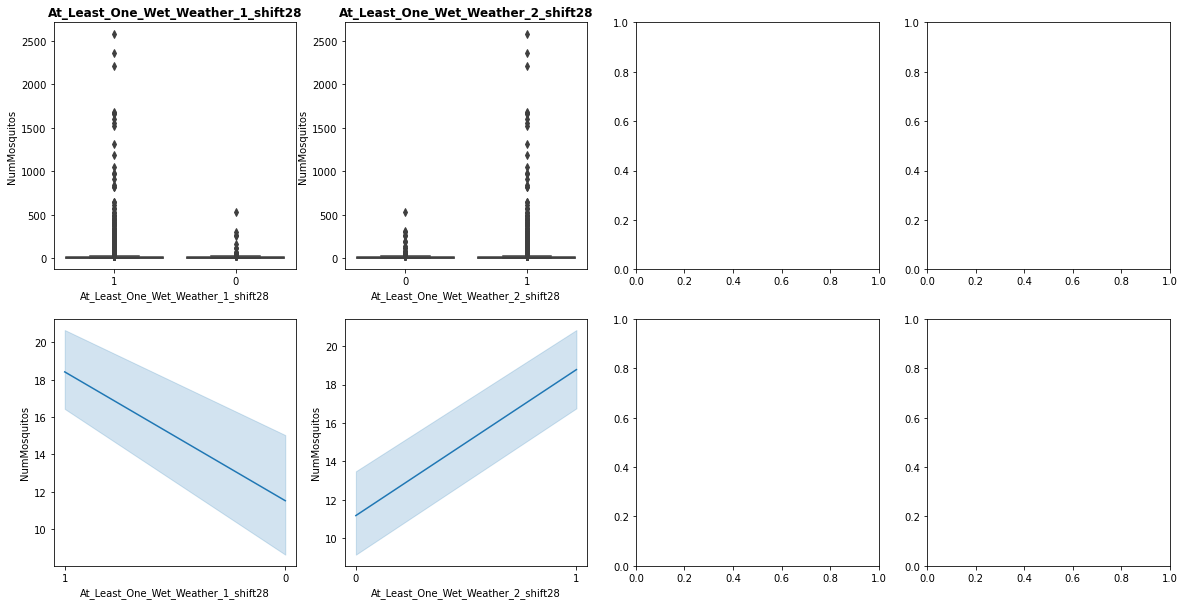

In [82]:
predictors = columnsOfInterest[8:10]
plot_4_boxplot_lineplot(train_weather_weekly, x_list=predictors, y_list=['NumMosquitos']*2,
                      plotTitle_list=predictors)